# Building a Minimally Correlated Portfolio with Data Science
The difficulty with modern portfolio theory is that correlations are non-stationary and harbours non-linear effects. On top of that financial data is incredibly sparse and Pearson's correlation only works on time series with equal dimensions. There is accumulating evidence that asset correlation networks, whose nodes are assets and whose edges are the pairwise correlations between the asset's historical returns follows a power-law distribution and show evidence of stationarity. In some sense one can say that these networks are governed by simple scale-free laws. It is known to be hard to forecast financial time series, but maybe the evolution of asset correlation networks is easier to predict if they are driven by simple laws, in which case these laws can be learned by a machine learning algorithm.

In the case of asset correlation networks, we are interested in how volatility spreads between assets between assets and how we can use these insights to optimize our portfolio. To do this we can look at the concept of communicability of complex networks to investigate how things spread and which nodes have the greatest influence in the process. Overall, we will use insights from network science to build centrality-based risk model to generate portfolio asset weights. 


## Background
In this series we play the part of an Investment Data Scientist at [Bridgewater Associates](https://www.bridgewater.com/) performing a go/no go analysis on a new idea for risk-weighted asset allocation. Our aim is to develop a network-based model for generating asset weights such that the probability of losing money in any given year is minimized. We've heard down the grapevine that all go-descisions will be presented to Dalio's inner circle at the end of the week and will likely be subject to intense scrutiny. As such, we work with a few highly correlated assets with strict go/no go criteria. We build the model using the daily prices of each stock (with a few replacements\*) in the Dow Jones Industrial Average (DJIA). If our recommended portfolio either (1) loses money in **any** year, (2) does not outperform the market **every** year, or (3) does not outperform the MPT portfolio---the decision is no go.

### Asset Diversification and Allocation
The building blocks of a portfolio are assets (resources with economic value expected to increase over time). Each asset belongs to one of seven primary asset classes: cash, equitiy, fixed income, commodities, real-estate, alternative assets, and more recently, digital (such as cryptocurrency and blockchain). Within each class are different asset types. For example: stocks, index funds, and equity mutual funds all belong to the equity class while gold, oil, and corn belong to the commodities class. An emerging consensus in the financial sector is this: a portfolio containing assets of many classes and types hedges against potential losses by increasing the number of revenue streams. In general the more diverse the portfolio the less likely it is to lose money. Take stocks for example. A diversified stock portfolio contains positions in multiple sectors. We call this *asset diversification*, or more simply *diversification*. Below is a table summarizing the asset classes and some of their respective types.

Cash | Equity | Fixed Income | Commodities | Real-Estate | Alternative Assets | Digital |
-----|--------|--------------|-------------|-------------|--------------------|---------|
US Dollar | US Stocks | US Bonds | Gold | REIT's | Structured Credit | Cryptocurrencies
Japenese Yen | Foreign Stocks | Foreign Bonds | Oil | Commerical Properties | Liquidations | Security Tokens
Chinese Yaun | Index Funds | Deposits | Wheat | Land | Aviation Assets | Online Stores
UK Pound | Mutual Funds | Debentures | Corn | Industrial Properties | Collectables | Online Media
 &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> |
 &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> |

**An investor solves the following (asset allocation) problem: given X dollars and N assets find the best possible way of breaking X into N pieces.** By "best possible" we mean maximizing our returns subject to minimizing the risk of our initial investment. In other words, we aim to consistently grow X irrespective of the overall state of the market. In what follows, we explore provocative insights by [Ray Dalio](https://en.wikipedia.org/wiki/Ray_Dalio) and others on portfolio construction.

# Exploratory Data Analysis and Cleaning
Before we dive into the asset allocation model, we first explore, clean, and preprocess our historical price data for time-series analyses. In this section we complete the following.
- Observe how many rows and columns are in our dataset and what they mean.
- Observe the datatypes of the columns and update them if needed.
- Take note of how the data is structured and what preprocessing will be necessary for time-series analyses.
- Deal with any missing data accordingly.
- Rename the stock tickers to the company names for readability.

In [0]:
#import data manipulation (pandas) and numerical manipulation (numpy) modules
import pandas as pd
import numpy as np

#silence warnings
import warnings
warnings.filterwarnings("ignore")

#reads the csv file into pandas DataFrame
df = pd.read_csv("https://github.com/firmai/random-assets/blob/master/all_stocks.csv?raw=true")

#prints first 5 rows of the DataFrame
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
1,2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2,2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
3,2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
4,2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM


* ```Date```: date (yyyy-mm-dd)
* ```Open```: daily opening prices (USD)
* ```High```: daily high prices (USD)
* ```Low```: daily low prices (USD)
* ```Close```: daily closing prices (USD)
* ```Volume``` daily volume (number of shares traded)
* ```Name```: ticker (abbreviates company name)

In [0]:
#prints last 5 rows
df.tail()

,Date,Open,High,Low,Close,Volume,Name
93607,2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
93608,2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
93609,2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA
93610,2017-12-28,70.12,70.32,69.51,69.82,7556877,AABA
93611,2017-12-29,69.79,70.13,69.43,69.85,6613070,AABA


In [0]:
#prints information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93612 entries, 0 to 93611
Data columns (total 7 columns):
Date      93612 non-null object
Open      93587 non-null float64
High      93602 non-null float64
Low       93592 non-null float64
Close     93612 non-null float64
Volume    93612 non-null int64
Name      93612 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 5.0+ MB


Some observations:

* The dataset has 93,612 rows and 7 columns. 
* The ```Date``` column is **not** a DateTime object (we need to change this).
* For time-series analyses we need to preprocess the data (we address this in the proceeding section).
* There are missing values in the ```Open```, ```High```, and ```Low``` columns (we adress this after preprocessing the data).
* We also want to map the tickers (e.g., MMM) to the company names (e.g., 3M).
* Finally, we need to set the index as the date.

In [0]:
#changes Date column to a DateTime object
df['Date'] = pd.to_datetime(df['Date'])

In [0]:
#prints unique tickers in the Name column
print(df['Name'].unique())

['MMM' 'AXP' 'AAPL' 'BA' 'CAT' 'CVX' 'CSCO' 'KO' 'DIS' 'XOM' 'GE' 'GS'
 'HD' 'IBM' 'INTC' 'JNJ' 'JPM' 'MCD' 'MRK' 'MSFT' 'NKE' 'PFE' 'PG' 'TRV'
 'UTX' 'UNH' 'VZ' 'WMT' 'GOOGL' 'AMZN' 'AABA']


In [0]:
#dictionary of tickers and their respective company names
ticker_mapping = {'AABA':'Altaba', 
                  'AAPL':'Apple', 
                  'AMZN': 'Amazon',
                  'AXP':'American Express',
                  'BA':'Boeing', 
                  'CAT':'Caterpillar',
                  'MMM':'3M', 
                  'CVX':'Chevron', 
                  'CSCO':'Cisco Systems',
                  'KO':'Coca-Cola', 
                  'DIS':'Walt Disney', 
                  'XOM':'Exxon Mobil',
                  'GE': 'General Electric',
                  'GS':'Goldman Sachs',
                  'HD': 'Home Depot',
                  'IBM': 'IBM',
                  'INTC': 'Intel',
                  'JNJ':'Johnson & Johnson',
                  'JPM':'JPMorgan Chase',
                  'MCD':'Mcdonald\'s',
                  'MRK':'Merk',
                  'MSFT':'Microsoft',
                  'NKE':'Nike',
                  'PFE':'Pfizer',
                  'PG':'Procter & Gamble',
                  'TRV':'Travelers',
                  'UTX':'United Technologies',
                  'UNH':'UnitedHealth',
                  'VZ':'Verizon',
                  'WMT':'Walmart',
                  'GOOGL':'Google'}

#changes the tickers in df to the company names
df['Name'] = df['Name'].map(ticker_mapping)

In [0]:
#sets the Date column as the index
df.set_index('Date', inplace=True)

# Preprocessing for Time-Series Analysis

In this section we do the following.

1. Break the data in two pieces: historical prices from 2006-2014 (``df_train``) and from 2015-2017 (``df_validate``). We build our model portfolio using the former and test it with the latter.
<br/><br/>
2. We add a column to ``df_train`` recording the difference between the daily closing and opening prices ```Close_diff```.
<br/><br/>
3. We create a seperate DataFrame for the ``Open``, ``High``, ``Low``, ``Close``, and ``Close_diff`` time-series.
    * Pivot the tickers in the ``Name`` column of ``df_train`` to the column names of the above DataFrames and set the values as the daily prices 
<br/><br/>
4. Transform each time-series so that it's stationary.
    * We do this by detrending with the pd.diff() method
<br/><br/>
5. Finally, remove the missing data.

In [0]:
#traning dataset
df_train = df.loc['2006-01-03':'2015-01-01']
df_train.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2014-12-24,50.19,50.92,50.19,50.65,5962870,Altaba
2014-12-26,50.65,51.06,50.61,50.86,5170048,Altaba
2014-12-29,50.67,51.01,50.51,50.53,6624489,Altaba
2014-12-30,50.35,51.27,50.35,51.22,10703455,Altaba
2014-12-31,51.54,51.68,50.46,50.51,9305013,Altaba


In [0]:
#testing dataset
df_validate = df.loc['2015-01-01':'2017-12-31']
df_validate.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,71.42,71.87,71.22,71.58,10979165,Altaba
2017-12-26,70.94,71.39,69.63,69.86,8542802,Altaba
2017-12-27,69.77,70.49,69.69,70.06,6345124,Altaba
2017-12-28,70.12,70.32,69.51,69.82,7556877,Altaba
2017-12-29,69.79,70.13,69.43,69.85,6613070,Altaba


It's always a good idea to check we didn't lose any data after the split.

In [0]:
#returns True if no data was lost after the split and False otherwise.
df_train.shape[0] + df_validate.shape[0] == df.shape[0]

True

In [0]:
# sets each column as a stock and every row as a daily closing price
df_validate = df_validate.pivot(columns='Name', values='Close')

In [0]:
df_validate.head()

Name,3M,Altaba,Amazon,American Express,Apple,Boeing,Caterpillar,Chevron,Cisco Systems,Coca-Cola,Exxon Mobil,General Electric,Goldman Sachs,Google,Home Depot,IBM,Intel,JPMorgan Chase,Johnson & Johnson,Mcdonald's,Merk,Microsoft,Nike,Pfizer,Procter & Gamble,Travelers,United Technologies,UnitedHealth,Verizon,Walmart,Walt Disney
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,164.06,50.17,308.52,93.02,109.33,129.95,91.88,112.58,27.61,42.14,92.83,25.06,194.41,529.55,103.43,162.06,36.36,62.49,104.52,93.26,57.19,46.76,47.52,31.33,90.44,105.44,115.04,100.78,46.96,85.90,93.75
2015-01-05,160.36,49.13,302.19,90.56,106.25,129.05,87.03,108.08,27.06,42.14,90.29,24.60,188.34,519.46,101.26,159.51,35.95,60.55,103.79,92.23,58.04,46.32,46.75,31.16,90.01,104.17,113.12,99.12,46.57,85.65,92.38
2015-01-06,158.65,49.21,295.29,88.63,106.26,127.53,86.47,108.03,27.05,42.46,89.81,24.07,184.53,506.64,100.95,156.07,35.28,58.98,103.28,92.40,60.32,45.65,46.48,31.42,89.60,103.24,111.52,98.92,47.04,86.31,91.89
2015-01-07,159.80,48.59,298.42,90.30,107.75,129.51,87.81,107.94,27.30,42.99,90.72,24.08,187.28,505.15,104.41,155.05,36.02,59.07,105.56,94.01,61.61,46.23,47.44,31.85,90.07,105.00,112.73,99.93,46.19,88.60,92.83
2015-01-08,163.63,50.23,300.46,91.58,111.89,131.80,88.71,110.41,27.51,43.51,92.23,24.37,190.27,506.91,106.72,158.42,36.69,60.39,106.39,94.36,62.85,47.59,48.53,32.50,91.10,107.18,114.65,104.70,47.18,90.47,93.79


In [0]:
#creates a new column with the difference beteween the closing and opening prices
df_train['Close_Diff'] = df_train.loc[:,'Close'] - df_train.loc[:,'Open']

In [0]:
df_train.head()

,Open,High,Low,Close,Volume,Name,Close_Diff
Date,,,,,,,
2006-01-03,77.76,79.35,77.24,79.11,3117200,3M,1.35
2006-01-04,79.49,79.49,78.25,78.71,2558000,3M,-0.78
2006-01-05,78.41,78.65,77.56,77.99,2529500,3M,-0.42
2006-01-06,78.64,78.90,77.64,78.63,2479500,3M,-0.01
2006-01-09,78.50,79.83,78.46,79.02,1845600,3M,0.52


In [0]:
#creates a DataFrame for each time-series (see In [11])
df_train_close = df_train.pivot(columns='Name', values='Close')
df_train_open = df_train.pivot(columns='Name', values='Open')
df_train_close_diff = df_train.pivot(columns='Name', values='Close_Diff')
df_train_high = df_train.pivot(columns='Name', values='High')
df_train_low = df_train.pivot(columns='Name', values='Low')

#makes a copy of the traning dataset
df_train_close_copy = df_train_close.copy()

df_train_close.head()

Name,3M,Altaba,Amazon,American Express,Apple,Boeing,Caterpillar,Chevron,Cisco Systems,Coca-Cola,Exxon Mobil,General Electric,Goldman Sachs,Google,Home Depot,IBM,Intel,JPMorgan Chase,Johnson & Johnson,Mcdonald's,Merk,Microsoft,Nike,Pfizer,Procter & Gamble,Travelers,United Technologies,UnitedHealth,Verizon,Walmart,Walt Disney
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-03,79.11,40.91,47.58,52.58,10.68,70.44,57.80,59.08,17.45,20.45,58.47,35.37,128.87,217.83,41.24,82.06,25.57,40.19,61.63,33.52,32.75,26.84,10.74,23.78,58.78,45.99,56.53,61.73,30.38,46.23,24.40
2006-01-04,78.71,40.97,47.25,51.95,10.71,71.17,59.27,58.91,17.85,20.41,58.57,35.32,127.09,222.84,40.48,81.95,25.91,39.62,62.58,33.82,33.13,26.97,10.69,24.55,58.89,46.50,56.19,61.88,31.27,46.32,23.99
2006-01-05,77.99,41.53,47.65,52.50,10.63,70.33,59.27,58.19,18.35,20.51,58.28,35.23,127.04,225.85,40.08,82.50,26.27,39.74,62.32,33.86,33.18,26.99,10.76,24.58,58.70,46.95,55.98,61.69,31.63,45.69,24.41
2006-01-06,78.63,43.21,47.87,52.68,10.90,69.35,60.45,59.25,18.77,20.70,59.43,35.47,128.84,233.06,40.38,84.95,26.31,40.02,62.60,34.06,33.12,26.91,10.72,24.85,58.64,47.21,56.16,62.90,31.35,45.88,24.74
2006-01-09,79.02,43.42,47.08,53.99,10.86,68.77,61.55,58.95,19.06,20.80,59.40,35.38,130.39,233.68,40.82,83.73,26.47,40.67,62.99,34.71,33.66,26.86,10.88,24.85,59.08,47.23,56.80,61.40,31.48,45.71,25.00


## Detrending and Additional Data Cleaning


In [0]:
#creates a list of stocks
stocks = df_train_close.columns.tolist()

#list of training DataFrames containing each time-series
df_train_list = [df_train_close, df_train_open, df_train_close_diff, df_train_high, df_train_low]

#detrends each time-series for each DataFrame
for df in df_train_list:
    for s in stocks:
        df[s] = df[s].diff()

In [0]:
df_train_close.head()

Name,3M,Altaba,Amazon,American Express,Apple,Boeing,Caterpillar,Chevron,Cisco Systems,Coca-Cola,Exxon Mobil,General Electric,Goldman Sachs,Google,Home Depot,IBM,Intel,JPMorgan Chase,Johnson & Johnson,Mcdonald's,Merk,Microsoft,Nike,Pfizer,Procter & Gamble,Travelers,United Technologies,UnitedHealth,Verizon,Walmart,Walt Disney
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,-0.40,0.06,-0.33,-0.63,0.03,0.73,1.47,-0.17,0.40,-0.04,0.10,-0.05,-1.78,5.01,-0.76,-0.11,0.34,-0.57,0.95,0.30,0.38,0.13,-0.05,0.77,0.11,0.51,-0.34,0.15,0.89,0.09,-0.41
2006-01-05,-0.72,0.56,0.40,0.55,-0.08,-0.84,0.00,-0.72,0.50,0.10,-0.29,-0.09,-0.05,3.01,-0.40,0.55,0.36,0.12,-0.26,0.04,0.05,0.02,0.07,0.03,-0.19,0.45,-0.21,-0.19,0.36,-0.63,0.42
2006-01-06,0.64,1.68,0.22,0.18,0.27,-0.98,1.18,1.06,0.42,0.19,1.15,0.24,1.80,7.21,0.30,2.45,0.04,0.28,0.28,0.20,-0.06,-0.08,-0.04,0.27,-0.06,0.26,0.18,1.21,-0.28,0.19,0.33
2006-01-09,0.39,0.21,-0.79,1.31,-0.04,-0.58,1.10,-0.30,0.29,0.10,-0.03,-0.09,1.55,0.62,0.44,-1.22,0.16,0.65,0.39,0.65,0.54,-0.05,0.16,0.00,0.44,0.02,0.64,-1.50,0.13,-0.17,0.26


In [0]:
#counts the missing values in each column
df_train_close.isnull().sum()

Name
3M                     1
Altaba                 3
Amazon                 3
American Express       1
Apple                  3
Boeing                 1
Caterpillar            1
Chevron                1
Cisco Systems          3
Coca-Cola              1
Exxon Mobil            1
General Electric       1
Goldman Sachs          1
Google                 3
Home Depot             1
IBM                    1
Intel                  3
JPMorgan Chase         1
Johnson & Johnson      1
Mcdonald's             1
Merk                   3
Microsoft              3
Nike                   1
Pfizer                 1
Procter & Gamble       1
Travelers              1
United Technologies    1
UnitedHealth           1
Verizon                1
Walmart                1
Walt Disney            1
dtype: int64

Since the number of missing values in every column is considerably less than 1% of the total number of rows (93,612) we can safely drop them.

In [0]:
#drops all missing values in each DataFrame
for df in df_train_list:
    df.dropna(inplace=True)

# Building an Asset Correlation Network

Now that the data is preprocessed we can start thinking our way through the problem creatively. To refresh our memory, let's restate the problem.

**Given the $N$ assets in our portfolio, find a way of computing the allocation weights $w_{i}$, $\Big( \sum_{i=1}^{N}w_{i}=1\Big)$ such that assets more correlated with each other obtain lower weights while those less correlated with each other obtain higher weights.**

One way of tackling the above is to think of our portfolio as a weighted [graph](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)). Intuitively, a graph captures the relations between objects -- abstract or concrete. Mathematically, a weighted graph is an ordered tuple &thinsp;$G = (V, E, W)$&thinsp; where &thinsp;$V$&thinsp; is a set of *vertices* (or *nodes*), &thinsp;$E$&thinsp; is the set of pairwise relationships between the vertices (the *edges*), and $W$ is a set of numerical values assigned to each edge. 
<br/><br/>
![](https://upload.wikimedia.org/wikipedia/commons/9/9a/Weighted_network.png)
<center>A weighted graph with ten vertices and twelve edges.</center>
<br/><br/>

A useful represention of &thinsp;$G$&thinsp; is the *adjacency matrix*:

<center>$$
A_{ij} = \begin{cases} 
      1, & \text{if} \ i \ \text{is adjacent to} \ j \  \\
      0, & \text{otherwise}
   \end{cases}
$$</center>
    
Here the pairwise relations are expressed as the $ij$ entries of an $N \times N$ matrix where $N$ is the number of nodes. In what follows, the adjacency matrix becomes a critical instrument of our asset allocation algorithm. **Our strategy is to transform the historical pricing data into a graph with edges weighted by the correlations between each stock.** Once the time series data is in this form, we use graph centrality measures and graph algorithms to obtain the desired allocation weights. To construct the weighted graph we adopt the winner-take-all method presented by [Tse, *et al*. (2010)](http://cktse.eie.polyu.edu.hk/pdf-paper/JoEF-1009.pdf) with a few modifications. (See [Stock Correlation Network](https://en.wikipedia.org/wiki/Stock_correlation_network) for a summary.) Our workflow in this section is as follows.

1. We compute the *distance correlation matrix* $\rho_{D}(X_{i}, X_{j})$ for the ``Open``, ``High``, ``Low``, ``Close``, and ``Close_diff`` time series.
2. We use the NetworkX module to transform each distance correlation matrix into a weighted graph.
3. We adopt the winner-take-all method and remove edges with correlations below a threshold value of $\rho_{c} = 0.325$,

<br/><br/>
<center>$$\text{Cor}_{ij} = \begin{cases} 
      \rho_{D}(X_{i}, Y_{j}), & \rho \geq \rho_{c}  \\
      0, & \text{otherwise}.
   \end{cases}$$</center>
   
    *Note a threshold value of 0.325 is arbitrary. In practice, the threshold cannot be such that the graph is disconnected, as many centrality measures are undefined for nodes without any connections.

4. We inspect the distribution of edges (the so-called degree distribution) for each network. The degree of a node is simply the number of connections it has to other nodes. Algebraically, the degree of the *i*th vertex is given as,

<br/><br/>
<center>$$\text{Deg}(i) = \sum_{j=1}^{N}A_{ij}$$</center>

5. Finally, we build a master network by averaging over the edge weights of the ``Open``, ``High``, ``Low``, ``Close``, and ``Close_diff`` networks and derive the asset weights from its structure.

## What on Earth is Distance Correlation and Why Should We Care?

Put simply, [Distance correlation](https://en.wikipedia.org/wiki/Distance_correlation#cite_note-SR2007-2) is a generalization of Pearson's correlation insofar as it (1) detects both linear and non-linear associations in the data and (2) can be applied to time series of unequal dimension. Below is a comparison of the Distance  and Pearson correlation.
<br/><br/>

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/400px-Correlation_examples2.svg.png)
<center>Pearson's correlation coefficients of sample data</center>

<br/><br/>
![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Distance_Correlation_Examples.svg/400px-Distance_Correlation_Examples.svg.png)
<center>Distance correlation coefficients of sample data</center>

Distance correlation varies between 0 and 1. A Distance correlation close to 0 indicates a pair of time series is **independent** where values close to 1 indicate a high degree of **dependence**. This is in contrast to Pearson's correlation which varies between -1 and 1 and can be 0 for time series that are dependent (see [Szekely, *et al*. (2017)](https://arxiv.org/pdf/0803.4101.pdf)). What makes Distance correlation particularly  appealing is the fact that it can be applied to time series of unequal dimension. If our ultimate goal is to scale the asset allocation algorithm to the *entire* market (with time series of many assets) and update it in real-time (which it is), the algo must be able to handle time series of arbitrary dimension. The penultimate goal is to observe how an asset correlation network *representative* of the global market evolves in real-time and update the allocation weights in response.

### Calculating the Distance Correlation Matrix with dcor

In [0]:
#imports the dcor module to calculate distance correlation
import dcor

#function to compute the distance correlation (dcor) matrix from a DataFrame and output a DataFrame 
#of dcor values.
def df_distance_correlation(df_train):
    
    #initializes an empty DataFrame
    df_train_dcor = pd.DataFrame(index=stocks, columns=stocks)
    
    #initialzes a counter at zero
    k=0
    
    #iterates over the time series of each stock
    for i in stocks:
        
        #stores the ith time series as a vector
        v_i = df_train.loc[:, i].values
        
        #iterates over the time series of each stock subect to the counter k
        for j in stocks[k:]:
            
            #stores the jth time series as a vector
            v_j = df_train.loc[:, j].values
            
            #computes the dcor coefficient between the ith and jth vectors
            dcor_val = dcor.distance_correlation(v_i, v_j)
            
            #appends the dcor value at every ij entry of the empty DataFrame
            df_train_dcor.at[i,j] = dcor_val
            
            #appends the dcor value at every ji entry of the empty DataFrame
            df_train_dcor.at[j,i] = dcor_val
        
        #increments counter by 1
        k+=1
    
    #returns a DataFrame of dcor values for every pair of stocks
    return df_train_dcor

In [0]:
df_train_dcor_list = [df_distance_correlation(df) for df in df_train_list]

In [0]:
df_train_dcor_list[4].head()

,3M,Altaba,Amazon,American Express,Apple,Boeing,Caterpillar,Chevron,Cisco Systems,Coca-Cola,Exxon Mobil,General Electric,Goldman Sachs,Google,Home Depot,IBM,Intel,JPMorgan Chase,Johnson & Johnson,Mcdonald's,Merk,Microsoft,Nike,Pfizer,Procter & Gamble,Travelers,United Technologies,UnitedHealth,Verizon,Walmart,Walt Disney
3M,1,0.353645,0.39234,0.537989,0.349158,0.499624,0.548548,0.504802,0.470029,0.431732,0.493843,0.571459,0.458415,0.445151,0.449654,0.508049,0.478602,0.495971,0.452308,0.405659,0.379369,0.455552,0.450839,0.414834,0.401242,0.470891,0.613992,0.359024,0.396697,0.357485,0.535781
Altaba,0.353645,1,0.351135,0.341589,0.290445,0.312507,0.315713,0.267452,0.343121,0.246817,0.275439,0.322856,0.335161,0.394651,0.296938,0.308619,0.321244,0.314992,0.237001,0.214202,0.221328,0.302109,0.31163,0.24649,0.218293,0.269813,0.337054,0.211276,0.218758,0.209349,0.37071
Amazon,0.39234,0.351135,1,0.387674,0.373537,0.349593,0.383719,0.31787,0.35512,0.277101,0.305706,0.347598,0.336959,0.488677,0.380288,0.362825,0.34934,0.336473,0.296485,0.294978,0.261685,0.340249,0.3993,0.274551,0.220758,0.296325,0.402777,0.244168,0.265955,0.254739,0.402439
American Express,0.537989,0.341589,0.387674,1,0.351312,0.468953,0.472919,0.423415,0.455908,0.383586,0.415759,0.535171,0.549353,0.456379,0.485761,0.455377,0.449951,0.589733,0.402903,0.386209,0.364685,0.441841,0.450744,0.421407,0.354739,0.476044,0.535638,0.328788,0.393664,0.373938,0.505921
Apple,0.349158,0.290445,0.373537,0.351312,1,0.296182,0.388631,0.303327,0.331026,0.235683,0.272383,0.315512,0.331691,0.417814,0.297929,0.364163,0.332603,0.328816,0.228657,0.256327,0.218543,0.316923,0.317469,0.224457,0.199562,0.265335,0.343254,0.227484,0.229273,0.191001,0.346844


### Building a Time-Series Correlation Network with Networkx

In [0]:
#imports the NetworkX module
import networkx as nx

# takes in a pre-processed dataframe and returns a time-series correlation
# network with pairwise distance correlation values as the edges
def build_corr_nx(df_train):
    
    # converts the distance correlation dataframe to a numpy matrix with dtype float
    cor_matrix = df_train.values.astype('float')
    
    # Since dcor ranges between 0 and 1, (0 corresponding to independence and 1
    # corresponding to dependence), 1 - cor_matrix results in values closer to 0
    # indicating a higher degree of dependence where values close to 1 indicate a lower degree of 
    # dependence. This will result in a network with nodes in close proximity reflecting the similarity
    # of their respective time-series and vice versa.
    sim_matrix = 1 - cor_matrix
    
    # transforms the similarity matrix into a graph
    G = nx.from_numpy_matrix(sim_matrix)
    
    # extracts the indices (i.e., the stock names from the dataframe)
    stock_names = df_train.index.values
    
    # relabels the nodes of the network with the stock names
    G = nx.relabel_nodes(G, lambda x: stock_names[x])
    
    # assigns the edges of the network weights (i.e., the dcor values)
    G.edges(data=True)
    
    # copies G
    ## we need this to delete edges or othwerwise modify G
    H = G.copy()
    
    # iterates over the edges of H (the u-v pairs) and the weights (wt)
    for (u, v, wt) in G.edges.data('weight'):
        # selects edges with dcor values less than or equal to 0.33
        if wt >= 1 - 0.325:
            # removes the edges 
            H.remove_edge(u, v)
            
        # selects self-edges
        if u == v:
            # removes the self-edges
            H.remove_edge(u, v)
    
    # returns the final stock correlation network            
    return H

In [0]:
#builds the distance correlation networks for the Open, Close, High, Low, and Close_diff time series
H_close = build_corr_nx(df_train_dcor_list[0])
H_open = build_corr_nx(df_train_dcor_list[1])
H_close_diff = build_corr_nx(df_train_dcor_list[2])
H_high = build_corr_nx(df_train_dcor_list[3])
H_low = build_corr_nx(df_train_dcor_list[4])

### Plotting a Time-Series Correlation Network with Seaborn

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
# function to display the network from the distance correlation matrix
def plt_corr_nx(H, title):

    # creates a set of tuples: the edges of G and their corresponding weights
    edges, weights = zip(*nx.get_edge_attributes(H, "weight").items())

    # This draws the network with the Kamada-Kawai path-length cost-function.
    # Nodes are positioned by treating the network as a physical ball-and-spring system. The locations
    # of the nodes are such that the total energy of the system is minimized.
    pos = nx.kamada_kawai_layout(H)

    with sns.axes_style('whitegrid'):
        # figure size and style
        plt.figure(figsize=(12, 9))
        plt.title(title, size=16)

        # computes the degree (number of connections) of each node
        deg = H.degree

        # list of node names
        nodelist = []
        # list of node sizes
        node_sizes = []

        # iterates over deg and appends the node names and degrees
        for n, d in deg:
            nodelist.append(n)
            node_sizes.append(d)

        # draw nodes
        nx.draw_networkx_nodes(
            H,
            pos,
            node_color="#DA70D6",
            nodelist=nodelist,
            node_size=np.power(node_sizes, 2.33),
            alpha=0.8,
            font_weight="bold",
        )

        # node label styles
        nx.draw_networkx_labels(H, pos, font_size=13, font_family="sans-serif", font_weight='bold')

        # color map
        cmap = sns.cubehelix_palette(3, as_cmap=True, reverse=True)

        # draw edges
        nx.draw_networkx_edges(
            H,
            pos,
            edge_list=edges,
            style="solid",
            edge_color=weights,
            edge_cmap=cmap,
            edge_vmin=min(weights),
            edge_vmax=max(weights),
        )

        # builds a colorbar
        sm = plt.cm.ScalarMappable(
            cmap=cmap, 
            norm=plt.Normalize(vmin=min(weights), 
            vmax=max(weights))
        )
        sm._A = []
        plt.colorbar(sm)

        # displays network without axes
        plt.axis("off")

#silence warnings   
import warnings
warnings.filterwarnings("ignore")

# Visualizing How A Portfolio is Correlated with Itself (with Physics)

The following visualizations are rendered with the [Kamada-Kawai method](http://jgaa.info/accepted/2002/HarelKoren2002.6.3.pdf), which treats each vertex of the graph as a mass and each edge as a spring. The graph is drawn by finding the list of vertex positions that minimize the total energy of the ball-spring system. The method treats the spring lengths as the weights of the graph, which is given by ``` 1 - cor_matrix ``` where ``` cor_matrix ``` is the distance correlation matrix. Nodes seperated by large distances reflect smaller correlations between their time series data, while nodes seperated by small distances reflect larger correlations. The minimum energy configuration consists of vertices with few connections experiencing a repulsive force and vertices with many connections feeling an attractive force. As such, nodes with a larger degree (more correlations) fall towards to the center of the visualization where nodes with a smaller degree (fewer correlations) are pushed outwards. For an overview of physics-based graph visualizations see the [Force-directed graph drawing](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).

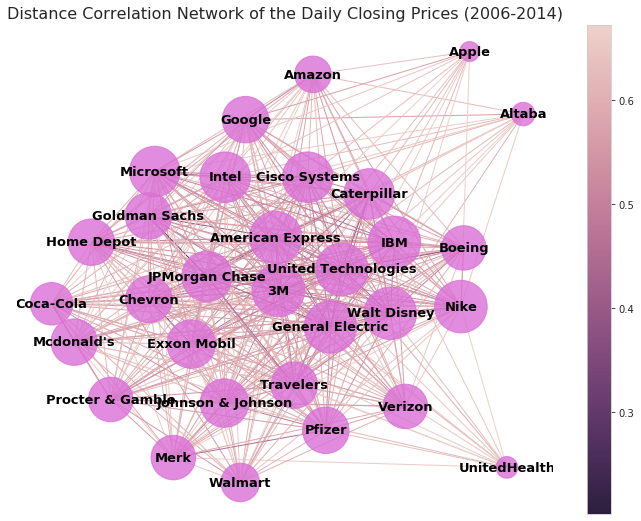

In [0]:
# plots the distance correlation network of the daily opening prices from 2006-2014
plt_corr_nx(H_close, title='Distance Correlation Network of the Daily Closing Prices (2006-2014)')

In the above visualization, the sizes of the vertices are proportional to the number of connections they have. The colorbar to the right indicates the degree of disimilarity (the distance) between the stocks. The larger the value (the lighter the color) the less similar the stocks are. Keeping this in mind, several stocks jump out. **Apple**, **Amazon**, **Altaba**, and **UnitedHealth** all lie on the periphery of the network with the fewest number of correlations above $\rho_{c} = 0.325$. On the other hand **3M**, **American Express**, **United Technolgies**, and **General Electric** sit in the core of the network with the greatest number connections above $\rho_{c} = 0.325$. It is clear from the closing prices network that our asset allocation algorithm needs to reward vertices on the periphery and punish those nearing the center. In the next code block we build a function to visualize how the edges of the distance correlation network are distributed.

## Degree Histogram

In [0]:
# function to visualize the degree distribution
def hist_plot(network, title, bins, xticks):
    
    # extracts the degrees of each vertex and stores them as a list
    deg_list = list(dict(network.degree).values())
    
    # sets local style
    with plt.style.context('fivethirtyeight'):
        # initializes a figure
        plt.figure(figsize=(9,6))

        # plots a pretty degree histogram with a kernel density estimator
        sns.distplot(
            deg_list,  
            kde=True,
            bins = bins,
            color='darksalmon',
            hist_kws={'alpha': 0.7}

        );

        # turns the grid off
        plt.grid(False)

        # controls the number and spacing of xticks and yticks
        plt.xticks(xticks, size=11)
        plt.yticks(size=11)

        # removes the figure spines
        sns.despine(left=True, right=True, bottom=True, top=True)

        # labels the y and x axis
        plt.ylabel("Probability", size=15)
        plt.xlabel("Number of Connections", size=15)

        # sets the title
        plt.title(title, size=20);

        # draws a vertical line where the mean is
        plt.axvline(sum(deg_list)/len(deg_list), 
                    color='darkorchid', 
                    linewidth=3, 
                    linestyle='--', 
                    label='Mean = {:2.0f}'.format(sum(deg_list)/len(deg_list))
        )

        # turns the legend on
        plt.legend(loc=0, fontsize=12)

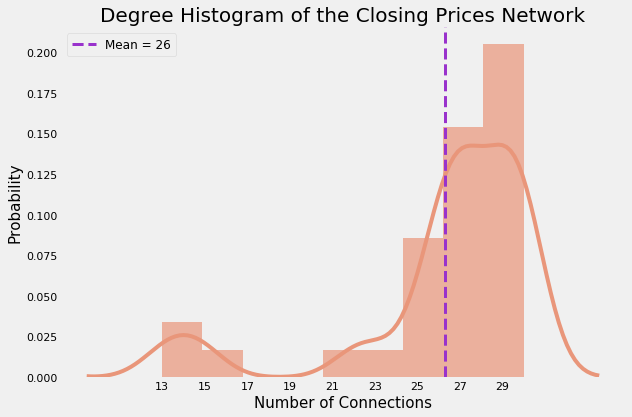

In [0]:
# plots the degree histogram of the closing prices network
hist_plot(
    H_close, 
    'Degree Histogram of the Closing Prices Network', 
    bins=9, 
    xticks=range(13, 30, 2)
)

**Observations**

* The degree distribution is left-skewed.
* The average node is connected to 86.6% of the network.
* Very few nodes are connected to less than 66.6% of the network. 
* The kernel density estimation is not a good fit.
* By eyeballing the plot, the degrees appear to follow an *inverse power-law* distribution. (This would be consistent with the findings of [Tse, *et al*. (2010)](http://cktse.eie.polyu.edu.hk/pdf-paper/JoEF-1009.pdf)).

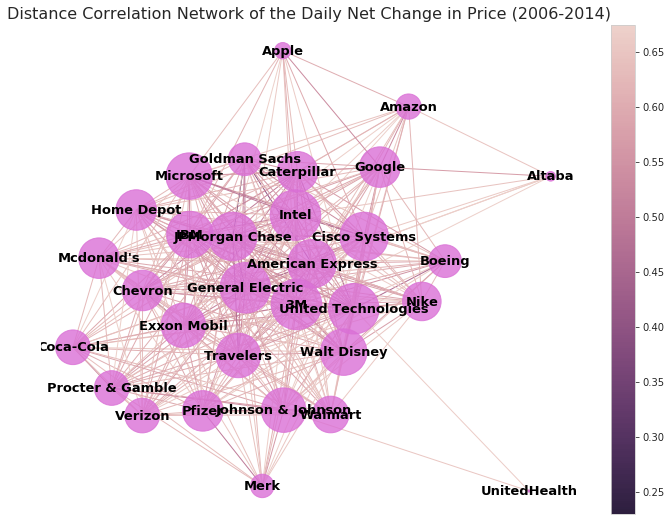

In [0]:
plt_corr_nx(
    H_close_diff, 
    title='Distance Correlation Network of the Daily Net Change in Price (2006-2014)'
)

**Observations**

* The above network has substantially fewer edges than the former.
* Apple, Amazon, Altaba, UnitedHealth, and Merck have the fewest number of correlations above $\rho_{c}$.
* 3M, General Electric, American Express, Walt Disney, and United Technologies have the greatest number of correlations above $\rho_{c}$.
* UnitedHealth is clearly an outlier with only two connections above $\rho_{c}$.

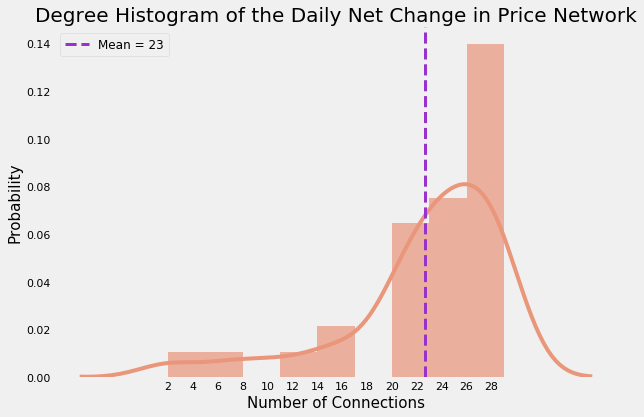

In [0]:
hist_plot(
    H_close_diff, 
    'Degree Histogram of the Daily Net Change in Price Network', 
    bins=9, 
    xticks=range(2, 30, 2)
)

**Observations:**

* The distribution is left-skewed.
* The average node is connected to 73.3% of the network.
* Very few nodes are connected to less than 53.3% of the network.
* The kernel density estimation is a poor fit.
* The degree distribution appears to follow an inverse power-law.

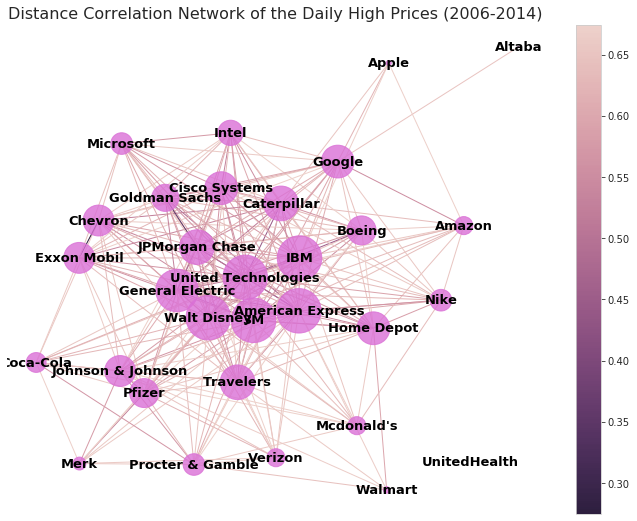

In [0]:
plt_corr_nx(
    H_high, 
    title='Distance Correlation Network of the Daily High Prices (2006-2014)'
)

**Observations**

* The above network has substantially fewer edges than the former two.
* Apple, Altaba, Amazon, Nike, Mcdonald's, UnitedHealth, Walmart, Procter & Gamble, Verizon, and Merck all lie on the periphery with the fewest number of correlations above $\rho_{c}$.
* UnitedHealth has **no** correlations above $\rho_{c}$.
* 3M, Walt Disney, General Electric, American Express, United Technologies, and IBM sit in the core with the greatest number of correlations above $\rho_{c}$.

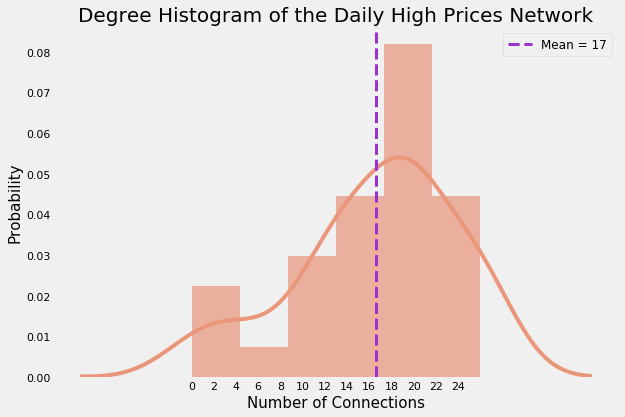

In [0]:
hist_plot(
    H_high, 
    'Degree Histogram of the Daily High Prices Network', 
    bins=6, 
    xticks=range(0,25,2)
)

**Observations**

* In contrast to the Daily Closing and Net Change in Price networks, the Daily High network is not significantly skewed.
* The average node is connected to 53.3% of the network.
* The kernel density estimation most closely resembles a Gaussian.

The degree distribution of the daily high prices certaintly stands out. It is the only distribution that is  most resembling a Gaussian --- something you expect to see if the data is truly random. This suggests daily high prices are driven mainly by impulse buys more reflective of random dice rolling than fundamentals.

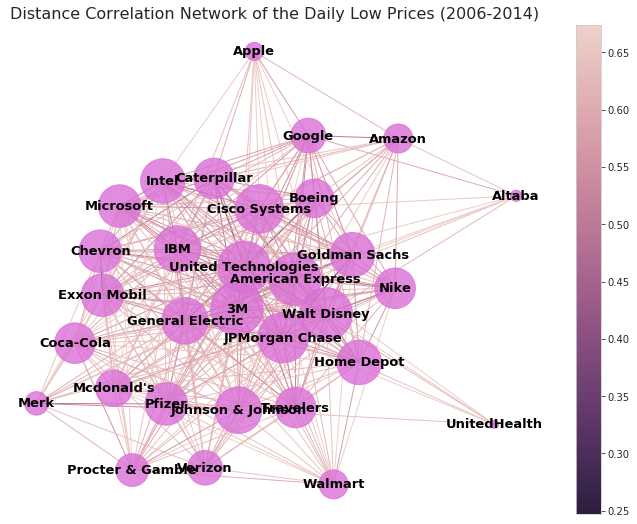

In [0]:
plt_corr_nx(
    H_low, 
    title='Distance Correlation Network of the Daily Low Prices (2006-2014)'
)

**Observations**

* The number of edges is comparable to the Daily Closing and Net Change in Price Networks.
* Apple, Amazon, Altaba, UnitedHealth, Walmart, Procter & Gamble, Merck, and Mcdonald's have the fewest number of correlations above $\rho_{c}$.
* 3M, American Express, United Technologies, Walt Disney, JPMorgan Chase, and General Electric have the greatest number of correlations above $\rho_{c}$.
* **UnitedHealth** has the overall fewest number of correlations above $\rho_{c}$.

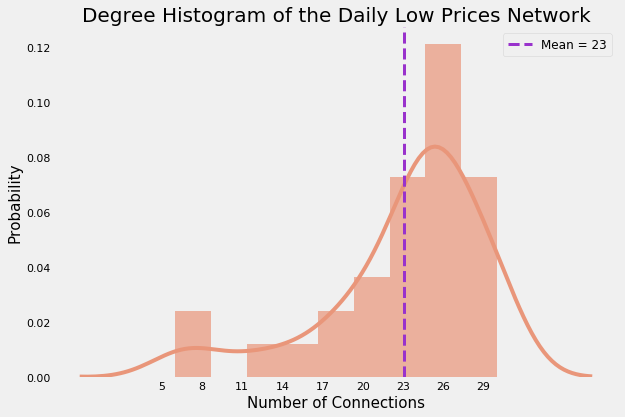

In [0]:
hist_plot(
    H_low, 
    'Degree Histogram of the Daily Low Prices Network', 
    bins=9, 
    xticks=range(5, 30, 3)
)

**Observations**

* The degree distribution of the Daily Low Prices network is left skewed.
* The average node is connected to 73.3% of the network.
* Most nodes are connected to greater than 66.6% of the network.
* Few nodes are connected to less than 50% of the network.
* The kernel density estimator is a poor fit.

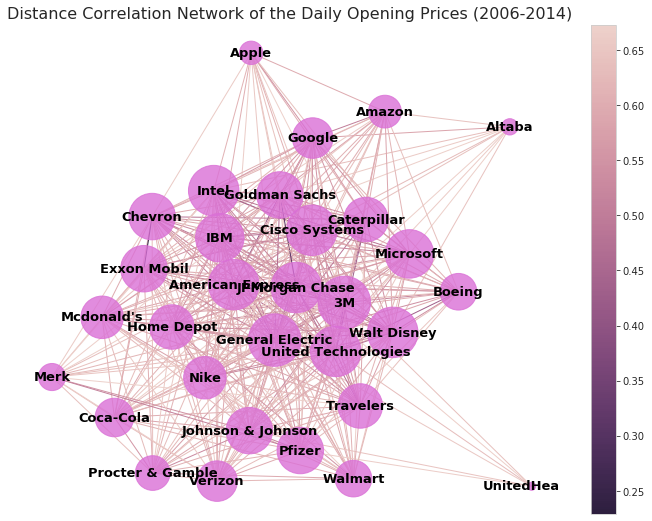

In [0]:
plt_corr_nx(
    H_open, 
    title='Distance Correlation Network of the Daily Opening Prices (2006-2014)'
)

**Observations**

* The number of edges of the Daily Opening Prices network is comparable to the the Daily Closing Prices network.
* Apple, Amazon, Altaba, UnitedHealth, Walmart, Verizon, Procter & Gamble, and Merck have the fewest number of correlations above $\rho_{c}$.
* 3M, General Electric, United Technologies, JPMorgan Chase, and American Express have the greatest number of correlations above $\rho_{c}$.
* **Unitedhealth** has the overall fewest number of correlations above $\rho_{c}$.

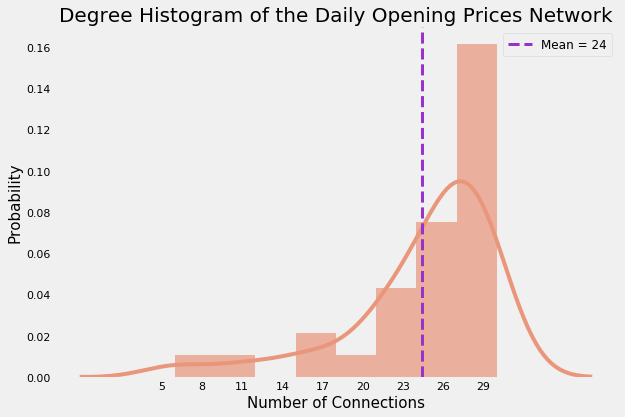

In [0]:
hist_plot(
    H_open, 
    'Degree Histogram of the Daily Opening Prices Network', 
    bins=8, 
    xticks= range(5, 30, 3)
)

**Observations**

* The degree distribution is strongly left skewed.
* The average node is connected to 80% of the network.
* Few nodes are connected to less than 50% of the network.
* The kernel density estimation provides a poor fit.
* The degree distribution appears to follow an inverse power-law.

# The Hedgecrafted Portfolio

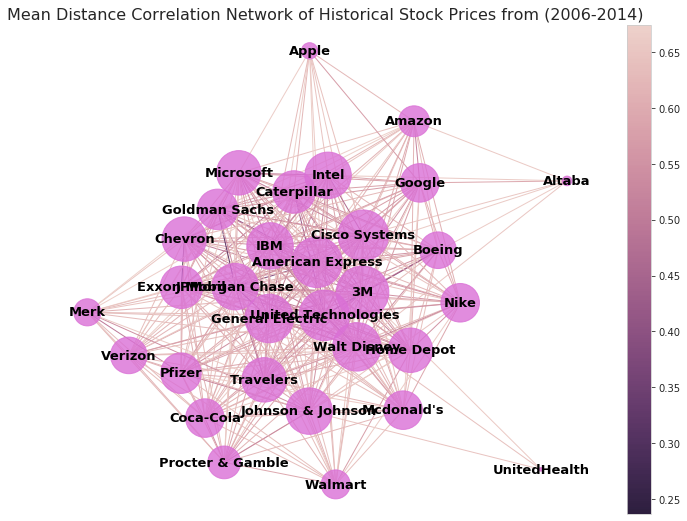

In [0]:
# initializes a DataFrame full of zeros
df_zeros = pd.DataFrame(index=stocks, columns=stocks).fillna(0)

# iterates over the length of the DataFrame list containg the Open, High, Low, Close, and Close_diff
# time series
for i in range(len(df_train_list)):
    
    # Adds the distance correlation DataFrames of the Open, High, Low, Close, and Close_diff
    # time series together
    df_zeros += df_train_dcor_list[i]
    
    # Takes the average of the distance correlation DataFrames
    df_master = df_zeros/len(df_train_list)

# Builds the master network with the averaged distance correlation DataFrame
H_master = build_corr_nx(df_master)

# Plots the master network
plt_corr_nx(
    H_master, 
    title='Mean Distance Correlation Network of Historical Stock Prices from (2006-2014)'
)

**Observations**

* Apple, Amazon, Altaba, UnitedHealth, Walmart, Procter & Gamble, and Merck have the fewest number of correlations above $\rho_{c}$.
* General Electric, American Express, 3M, United Technologies, and Walt Disney have the greatest number of correlations above $\rho_{c}$.
* **UnitedHealth** is the *least* correlated stock in our portfolio, followed by **Altaba** and **Apple**.
* **3M** is the *most* correlated, followed by **United Technologies** and **American Express**.

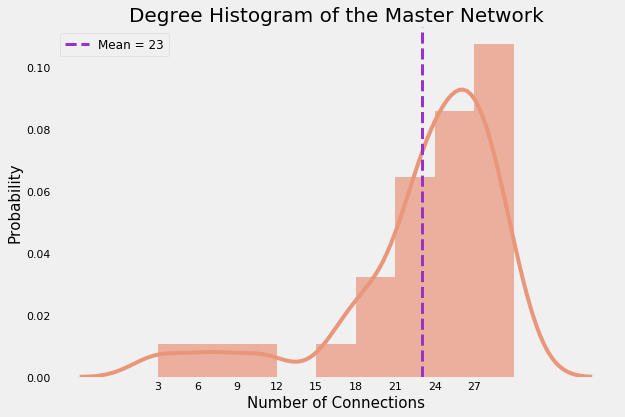

In [0]:
hist_plot(
    H_master, 
    'Degree Histogram of the Master Network', 
    bins=9, 
    xticks=range(3, 30, 3)
)

**Observations**

* The degree distribution is left skewed.
* The average node is connected to 76.6% of the network.
* Most nodes are connected to 66.6% of the network.
* Few nodes are connected to less than 50% of the network.

# Communicability as a Measure of Relative Risk

We are now in a position to devise a method to compute the allocation weights of our portfolio. To recall, this is the problem:

**Given the $N$ assets in our portfolio, find a way of computing the allocation weights $w_{i}$, &thinsp; $\Big( \sum_{i=1}^{N}w_{i}=1\Big)$ such that assets more correlated with each other obtain lower weights while those less correlated with each other obtain higher weights.**

Theres an infinite number of possible solutions to the above problem. The asset correlation network we built contains information on how our portfolio is interrelated (whose connected to who), but it does not tell us how each asset *impacts* the other or how those impacts travel throughout the network. If, for example, Apple's stock lost 40% of its value wiping out, say, two years of gains, how would this impact the remaining assets in our portfolio? How easily does this kind of behaviour spread and how can we keep our capital isolated from it? We thus seek a measure of "relative risk" that quantifies not only the correlations between assets, but how those correlations mediate perturbations in the portfolio. Our aim, therefore, is twofold: allocate capital inversely proportional to (1) the correlations between assets and (2) proportional to the "impact resistence" of each asset. As luck would have it, there is a [centrality](https://en.wikipedia.org/wiki/Centrality) measure that does just this! Let us define the relative risk as follows:

<br/><br/>
<center>$\text{Relative Risk of Asset} \ r$ = $\dfrac{\omega_{r}}{\sum_{r'=1}^{N}\omega_{r'}}$,</center>
<br/><br/>
where 
<center>$\omega_{r} = \dfrac{1}{C}\sum_{p}\sum_{q}\dfrac{G_{prq}}{G_{pq}}$</center>

is the **Communicability Betweenness centrality** [(Estrada, *et al.* (2009))](https://arxiv.org/pdf/0905.4102.pdf) of node $r$. Here
<br/><br/>
<center>$G_{prq} = \big(\exp{\textbf{A}}\big)_{pq} - \big(\exp{(\textbf{A} - \textbf{E}(r))}\big)_{pq}$</center>

is the number of weighted [walks](http://mathworld.wolfram.com/Walk.html) involving only node $r$,
<br/><br/>
<center>$G_{pq} = \big(\exp{\textbf{A}}\big)_{pq}$</center>

is the so-called *communicability* between nodes $p$ and $q$,
<br/><br/>
<center>$A_{pq} = \begin{cases} 
      1, & \text{if} \ \rho \geq \rho_{c}  \\
      0, & \text{otherwise}
   \end{cases}$</center>
   
is the adjacency matrix induced by the distance correlation matrix $\text{Cor}_{ij}$, and $\textbf{E}(r)$ is a matrix such that when added to $\textbf{A}$, yields a new graph $G(r) = (V, E')$ with all edges connecting $r \in V$ removed. The constant $C = (n-1)^2 - (n-1)$ normalizes $\omega_{r}$ such that it takes values between 0 and 1. We can better understand what $\omega_{r}$ is counting by re-writing the matrix exponential as a taylor series:
<br/><br/>

<center>$\exp{\textbf{A} = \sum_{k=1}^{\infty}}\dfrac{\textbf{A}^{k}}{k!}$</center>

Rasing the adjacency matrix to the power of $k$ counts all walks from $p$ to $q$ of length $k$. The matrix exponential therefore counts all possible ways of moving from $p$ to $q$ weighted by the inverse factorial of $k$. So the denominator of $\omega_{r}$ counts all weighted walks involving every node. Put simply,
<br/><br/>

<center>$\boxed{\text{Communicability Betweenees centrality} = \dfrac{\text{sum of all weighted walks involving node r}}{\text{sum of all weighted walks involving every node}}}$</center>

So the communicability betweenness centrality is proportional to the number of connections (correlations) a node has and therefore satisifies the first requirement of relative risk. Next, we explore how this measure quantifies the spread of impacts throughout the network, satisfying our second requirement.

## The Physics of what Communicability Measures

[Estrada & Hatano (2007)](https://arxiv.org/pdf/0707.0756.pdf) provided an ingenius argument showing the communicability of a network is identical to the Green's function of a network. That is, it measures how impacts (or more generally thermal fluctuations) travel from one node to another. Their argument works by treating each node as an oscillator and each edge as a spring (which is what we did to generate the visualization of our asset correlation network). Intuitively, we can draw an analogy between the movement of an asset's price and its motion in a ball-spring system. In this analogy, volatility is equivalent to how energetic the oscillator is. Revisiting the hypothetical scenerio of Apple losing 40% of its value: we can visualize this in our mind's eye as an impact to one of the masses---causing it to violently oscillate. How does this motion propagate throughout the rest of the ball-spring system? Which masses absorb the blow and which reflect it? Communicability betweeness centrality answers this question by counting all possible ways the impact can reach node $r$. Higher values indicate the node has a greater susceptiblility to impacts whereas lower values denote just the opposite.

# The Bottom Line

The communicability of a network quantifies how impacts spread from one node to another. In the context of an asset correlation network, communicability measures how volatility travels node to node. **We aim to position our capital such that it's the most resistant to the communicability of volatility**. Recall we seek a portfolio that (1) consistently generates wealth while minimizing potential losess and (2) is robust against large market fluctuations and economic downturns. Of course, generous returns are desired, but not in a way that threatens our initial investment. To this end, the strategy moving forward is this: allocate capital inversely proportional to its relative (or intraportfolio) risk.


## Intraportfolio Risk

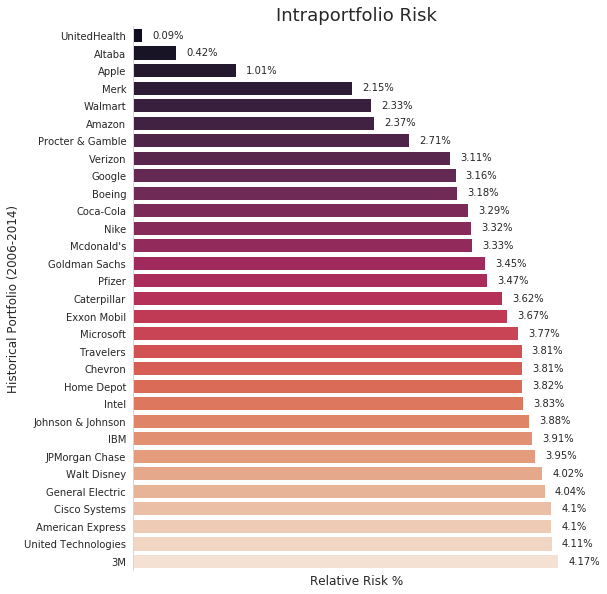

In [0]:
# calculates the communicability betweeness centrality and returns a dictionary
risk_alloc = nx.communicability_betweenness_centrality(H_master)

# converts the dictionary of degree centralities to a pandas series
risk_alloc = pd.Series(risk_alloc)

# normalizes the degree centrality 
risk_alloc = risk_alloc / risk_alloc.sum()

# resets the index
risk_alloc.reset_index()

# converts series to a sorted DataFrame
risk_alloc = (
    pd.DataFrame({"Stocks": risk_alloc.index, "Risk Allocation": risk_alloc.values})
        .sort_values(by="Risk Allocation", ascending=True)
        .reset_index()
        .drop("index", axis=1)
)

with sns.axes_style('whitegrid'):
    # initializes figure
    plt.figure(figsize=(8,10))

    # plots a pretty seaborn barplot
    sns.barplot(x='Risk Allocation', y='Stocks', data=risk_alloc, palette="rocket")

    # removes spines
    sns.despine(right=True, top=True, bottom=True)

    # turns xticks off
    plt.xticks([])

    # labels the x axis
    plt.xlabel("Relative Risk %", size=12)

    # labels the y axis
    plt.ylabel("Historical Portfolio (2006-2014)", size=12)

    # figure title
    plt.title("Intraportfolio Risk", size=18)

    # iterates over the stocks (label) and their numerical index (i)
    for i, label in enumerate(list(risk_alloc.index)):

        # gets the height of each bar in the barplot
        height = risk_alloc.loc[label, 'Risk Allocation']

        # gets the relative risk as a percentage (the labels)
        label = (risk_alloc.loc[label, 'Risk Allocation']*100 
                    ).round(2).astype(str) + '%'

        # annotates the barplot with the relative risk percentages
        plt.annotate(str(label), (height + 0.001, i + 0.15))

We read an intraportfolio risk plot like this: Altaba is $\dfrac{0.47}{0.09} = 4.66$ times riskier than UnitedHealth (UNH), Apple is $\dfrac{1.01}{0.09} = 11.22$ times more risky than UNH, ... , and 3M is a whopping $\dfrac{4.17}{0.09} = 46.33$ times riskier than UNH! Conversely, 3M is $\dfrac{4.17}{4.11} = 1.01$ times as risky as United Technologies, $\dfrac{4.17}{4.11} = 1.01$ times as risky as American Express, so on and so forth. Intuitively, the assets that cluster in the center of the network are most susceptible to impacts, whereas those further from the cluster are the least susceptible. The logic from here is straightforward: take the inverse of the relative risk (which we call the "relative certainty") and normalize it such that it adds to 1. These are the asset weights. Formally,
<br/><br/>
<center>$\text{w}_{r} = \dfrac{1}{\omega_{r} \sum_{r'}\omega_{r'}^{-1}}$</center>

Next, Let's visualize the allocation of 10,000 (USD) in our portfolio.

## Communicability-Based Asset Allocation

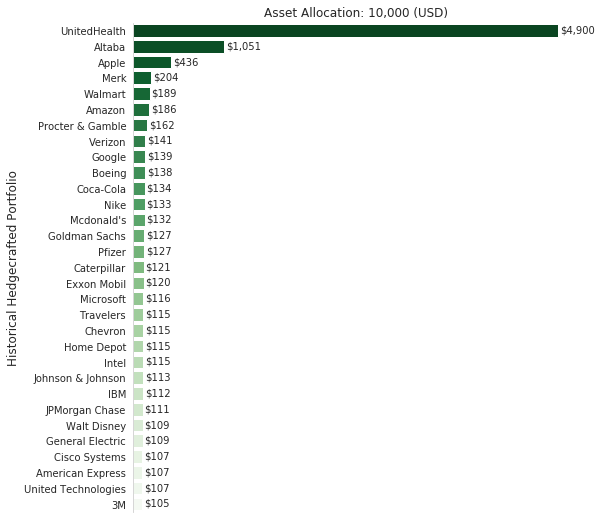

In [0]:
# calculates degree centrality and assigns it to investmnet_A
investment_A = nx.communicability_betweenness_centrality(H_master)

# calculates the inverse of the above and re-asigns it to investment_A as a pandas series
investment_A = 1 / pd.Series(investment_A)

# normalizes the above
investment_A = investment_A / investment_A.sum()

# resets the index
investment_A.reset_index()

# converts the above series to a sorted DataFrame
investment_A = (
    pd.DataFrame({"Stocks": investment_A.index, "Asset Allocation": investment_A.values})
        .sort_values(by="Asset Allocation", ascending=False)
        .reset_index()
        .drop("index", axis=1)
)

with sns.axes_style('whitegrid'):
    # initializes a figure
    plt.figure(figsize=(8,9))

    # plot a pretty seaborn barplot
    sns.barplot(x='Asset Allocation', y='Stocks', data=investment_A, palette="Greens_r")

    # despines the figure
    sns.despine(right=True, top=True, bottom=True)

    # turns xticks off
    plt.xticks([])

    # turns the x axis label off
    plt.xlabel('')

    # fig title
    plt.title("Asset Allocation: 10,000 (USD)", size=12)

    # y axis label
    plt.ylabel("Historical Hedgecrafted Portfolio", size=12)

    # captial to be allocated
    capital = 10000

    # iterates over the stocks (label) and their numerical indices (i)
    for i, label in enumerate(list(investment_A.index)):

        # gets the height of each bar
        height = investment_A.loc[label, 'Asset Allocation']

        # calculates the capital to be allocated
        label = (investment_A.loc[label, 'Asset Allocation'] * capital
                    ).round(2)

        # annotes the capital above each bar
        plt.annotate('${:,.0f}'.format(label), (height + 0.002, i + 0.15))

UnitedHealth recieves nearly 50%, Altaba gets about 10%, Apple 4%, Merck 2%, and the remaining assets recieve less than 2% of our capital. To the traditional invester, this strategy may appear "risky" since 60% of our investment is with 2 of our 31 assets. While it's true *if* UnitedHealth is hit hard we'll lose a substantial amount of money, our algorithm predicts UnitedHealth is the *least* likey to take a hit if and when our other assets get in trouble. UnitedHealth is clearly the winning pick in our portfolio.

It's worth pointing out that the methods we've used to generate the asset allocation weights differ dramatically from the contemporary methods of MPT and its extensions. The approach taken in this project makes no assumptions of future outcomes of a portfolio, i.e., the algorithm doesn't require us to make a prediction of the expected returns (as MPT does). What's more---we're not solving an optimization problem---there's nothing to be minimized or maximized. Instead, we observe the topology (interrelatedness) of our portfolio, predict which assets are the most susceptible to the communicability of volatile behaviour and allocate capital accordingly.

In [0]:
# DataFrame of the prices we buy stock at
df_buy_in = df_train_close_copy.loc['2014-12-31'].sort_index().to_frame('Buy In: 2014-12-31')

## Alternative Allocation Strategy: Allocate Capital in the Maximum Independent Set

The maximum independent set (MIS) is the largest set of vertices such that no two are adjacent. Applied to our asset correlation network, the MIS is the greatest number of assets such that every pair has a correlation below $\rho_{c} = 0.325$. The size of the MIS is inversely proportional to the threshold $\rho_{c}$. Larger values of $\rho_{c}$ produce a sparse network (more edges are removed) and therefore the MIS tends to be larger. An optimized portfolio would therefore correspond to maximizing the size of the MIS subject to minimizing $\rho_{c}$. The best way to do this is to increase the universe of assets we're willing to invest in. By further diversifying the portfolio with many asset types and classes, we can isolate the largest number of minimally correlated assets and allocate capital inversely proportional to their relative risk. While generating the asset weights remains a non-optimization problem, generating the asset correlation network *becomes* one. We're really solving two sepreate problems: determing how to build the asset correlation network (there are many) and determining which graph invariants (there are many) extract the asset weights from the network. As such, one can easily imagine a vast landscape of portfolios beyond that of MPT and a metric fuck-tonne of wealth to create. **Unfortunately, solving the MIS problem is NP-hard. The best we can do is find an approximation.**

## Using Expert Knowledge to Approximate the Maximum Independent Set

We have two options: randomly generate a list of maximal indpendent sets (subgraphs of $G$ such that no two vertices share an edge) and select the largest one, or use expert knowledge to reduce the number of sets to generate and do the latter. Both methods are imperfect, but the former is far more computationally expensive than the latter. Suppose we do fundamentals research and conclude UnitedHealth and Amazon must be in our portfolio. How could we imbue the algorithm with this knowledge? Can we make the algorithm flexible enough for portfolio managers to fine-tune with goold-ole' fashioned research, while at the same time keeping it rigged enough to prevent poor decisions from producing terribe portfolios? We confront this problem in the code block below by extracting an approximate MIS by generating 100 random maximal indpendent sets containing UnitedHealth and Amazon.

In [0]:
# a function to generate a random approximate MIS
### WARNING: rerunning kernel will produce different MISs
def generate_mis(G, sample_size, nodes=None):
    
    """Returns a random approximate maximum independent set.
    
    Parameters
    ----------
    G: NetworkX graph
       Undirected graph
       
    nodes: list, optional
        a list of nodes the approximate maximum independent set must contain.
    
    sample_size: int
        number of maximal independent sets sampled from
    
    Returns
    -------
    max_ind_set: list or None
        list of nodes in the apx-maximum independent set
        NoneType object if any two specified nodes share an edge
        
    """

    # list of maximal independent sets
    max_ind_set_list=[]

    # iterates from 0 to the number of samples chosen
    for i in range(sample_size):

        # for each iteration generates a random maximal independent set that contains 
        # UnitedHealth and Amazon
        max_ind_set = nx.maximal_independent_set(G, nodes=nodes, seed=i)
        
        # if set is not a duplicate
        if max_ind_set not in max_ind_set_list:

            # appends set to the above list
            max_ind_set_list.append(max_ind_set)
        
        # otherwise pass duplicate set    
        else:
            pass

    # list of the lengths of the maximal independent sets
    mis_len_list=[]

    # iterates over the above list
    for i in max_ind_set_list:

        # appends the lengths of each set to the above list
        mis_len_list.append(len(i))

    # extracts the largest maximal independent set, i.e., the maximum independent set (MIS)
    ## Note: this MIS may not be unique as it is possible there are many MISs of the same length
    max_ind_set = max_ind_set_list[mis_len_list.index(max(mis_len_list))]
    
    return max_ind_set



max_ind_set = generate_mis(H_master, nodes=['UnitedHealth', 'Amazon', 'Verizon'], sample_size=100)
print(max_ind_set)

['Verizon', 'UnitedHealth', 'Amazon', "Mcdonald's"]


The ```generate_mis``` function generates a maximal independent set that approximates the true maximum independent set. As an option, the user can pick a list of assets they want in their portfolio and ```generate_mis``` will return the safest assets to complement the user's choice. Picking UNH and AMZN left us with VZ and MCD. The weights of these assets will remain directly inversely proportional to the communicability betweeness centrality.

In [0]:
# prices of shares to buy for the MIS
df_mis_buy_in = df_buy_in.loc[list(max_ind_set)]
df_mis_buy_in

,Buy In: 2014-12-31
Name,
Verizon,46.78
UnitedHealth,101.09
Amazon,310.35
Mcdonald's,93.70


# Backtesting with Modern Portfolio Theory

Now that we have a viable alternative to portfolio optimization, it's time to see how the Hedgecraft portfolio performed in the validation years (15', 16', and 17') with respect to the Markowitz portfolio (i.e., the [efficient frontier](https://www.investopedia.com/video/play/explaining-efficient-frontier/) model) and the overall market. To summarize our workflow thus far we:

1. Preprocessed historical pricing data of 31 stocks for time series analyses.
2. Computed the distance correlation matrix $\rho_{D}(X_{i}, X_{j})$ for the ``Open``, ``High``, ``Low``, ``Close``, and ``Close_diff`` from 2006-2014.
3. Used the NetworkX module to transform each distance correlation matrix into a weighted graph.
4. Adopted the winner-take-all method by Tse, et al. and removed edges with correlations below a threshold value of $\rho_{c} = 0.325$.
5. Built a master network by averaging over the edge weights of the ``Open``, ``High``, ``Low``, ``Close``, and ``Close_diff`` networks.
6. Calculated the "relative risk" of each asset as the communicabality betweeness centrality assigned to each node.
7. Generated the asset weights as the normalized inverse of communicability betweeness centrality.

In addition to the above steps, we introduced a human-in-the-middle strategy, giving the user flexible control over the portfolio construction process. This is the extra step we added:

8. Adjust the asset weights for an approximate maximum independent set, either with or without human intervention.

To distinguish bewteen these two approaches we designate steps 1-7 as the *Hedgecraft* algo and steps 1-8 as the *Hedgecraft MIS* algo. Below we observe how these models perform with the Efficient Frontier as a benchmark.

## Generating Hedgecraft Portfolio Weights

In [0]:
# calculates communicability betweeness centrality
weights = nx.communicability_betweenness_centrality(H_master)

# dictionary comprehension of communicability centrality for the maximum independent set
mis_weights = {key: weights[key] for key in list(max_ind_set)}


# a function to convert centrality scores to portfolio weights
def centrality_to_portfolio_weights(weights):
    
    """Returns a dictionary of portfolio weights.
    
    Parameters
    ----------
    weights: dictionary
        NetworkX centrality scores
        
    Returns
    -------
    portfolio weights: dictionary
        normalized inverse of chosen centrality measure
        
    """

    # iterates over the key, value pairs in the weights dict
    for key, value in weights.items():

        # takes the inverse of the communicability betweeness centrality of each asset
        weights[key] = 1/value

    # normalization parameter for all weights to add to 1
    norm = 1.0 / sum(weights.values())

    # iterates over the keys (stocks) in the weights dict
    for key in weights:

        # updates each key value to the normalized value and rounds to 3 decimal places
        weights[key] = round(weights[key] * norm, 3)
        
    return weights
    


print(centrality_to_portfolio_weights(weights))
print('\n')
print(centrality_to_portfolio_weights(mis_weights))

{'3M': 0.011, 'Altaba': 0.105, 'Amazon': 0.019, 'American Express': 0.011, 'Apple': 0.044, 'Boeing': 0.014, 'Caterpillar': 0.012, 'Chevron': 0.012, 'Cisco Systems': 0.011, 'Coca-Cola': 0.013, 'Exxon Mobil': 0.012, 'General Electric': 0.011, 'Goldman Sachs': 0.013, 'Google': 0.014, 'Home Depot': 0.012, 'IBM': 0.011, 'Intel': 0.011, 'JPMorgan Chase': 0.011, 'Johnson & Johnson': 0.011, "Mcdonald's": 0.013, 'Merk': 0.02, 'Microsoft': 0.012, 'Nike': 0.013, 'Pfizer': 0.013, 'Procter & Gamble': 0.016, 'Travelers': 0.012, 'United Technologies': 0.011, 'UnitedHealth': 0.49, 'Verizon': 0.014, 'Walmart': 0.019, 'Walt Disney': 0.011}


{'Verizon': 0.026, 'UnitedHealth': 0.914, 'Amazon': 0.035, "Mcdonald's": 0.025}


Hedgecraft MIS allocates a staggering 91.4% of the investment to UNH. At first sight this portfolio appears far less diversified than Hedgecraft. However, if we recall, the relative risk of UNH was two orders of magnitude smaller than **every** other security (with the sole exception of Altaba). If our only options are the above 31 securities, the algorithm predicts UNH is the safest pick and allocates accordingly.

## Allocating Shares to the Hedgecraft Portfolio

In [0]:
# imports a tool to convert capital into shares
from pypfopt import discrete_allocation

# returns the number of shares to buy given the asset weights, prices, and capital to invest
alloc = discrete_allocation.DiscreteAllocation(
    weights, 
    df_buy_in['Buy In: 2014-12-31'], 
    total_portfolio_value=capital
)

# returns same as above but for the MIS
mis_alloc = discrete_allocation.DiscreteAllocation(
    mis_weights, 
    df_mis_buy_in['Buy In: 2014-12-31'],
    total_portfolio_value=capital
)

0 out of 31 tickers were removed
0 out of 4 tickers were removed


In [0]:
alloc = alloc.greedy_portfolio()[0]

mis_alloc = mis_alloc.greedy_portfolio()[0]

In [0]:
# converts above shares to a pandas series
alloc_series = pd.Series(alloc, name='Shares')

# names the series
alloc_series.index.name = 'Assets'

# resets index, prints assets with the shares we buy
alloc_series.reset_index
print(alloc_series)

print('\n')

# does same as above but for the MIS
mis_alloc_series = pd.Series(mis_alloc, name='MIS Shares')
mis_alloc_series.index.name = 'Assets'
mis_alloc_series.reset_index
print(mis_alloc_series)

Assets
UnitedHealth           48
Altaba                 20
Apple                   3
Merk                    3
Amazon                  1
Walmart                 2
Procter & Gamble        2
Boeing                  1
Google                  1
Verizon                 2
Coca-Cola               3
Goldman Sachs           1
Mcdonald's              1
Nike                    2
Pfizer                  4
Caterpillar             1
Chevron                 1
Exxon Mobil             1
Home Depot              1
Microsoft               2
Travelers               1
3M                      1
American Express        1
Cisco Systems           3
General Electric        4
IBM                     1
Intel                   3
JPMorgan Chase          1
Johnson & Johnson       1
United Technologies     0
Walt Disney             1
Name: Shares, dtype: int64


Assets
UnitedHealth    90
Amazon           1
Verizon          6
Mcdonald's       3
Name: MIS Shares, dtype: int64


In [0]:
# converts Hedgecraft shares series to a DataFrame
df_alloc = alloc_series.sort_index().to_frame('Shares')

# converts Hedgecraft MIS shares series to a DataFrame
df_mis_alloc = mis_alloc_series.sort_index().to_frame('MIS Shares')

##  The Efficient Frontier

Harry Markowitz's 1952 paper [Portfolio Selection](https://www.math.ust.hk/~maykwok/courses/ma362/07F/markowitz_JF.pdf) transformed portfolio management from an art to a science. Markowitz's key insight came from diversification: by combinining uncorrelated assets with different expected returns and volatilities, one can calculate an optimal allocation.

The main idea is this: if $w$ is the fraction of capital to be allocated to some asset, then the portfolio risk in terms of the covariance matrix $\Sigma$ is given by $w^{\top}\Sigma w$ and its expected returns are given by $w^{\top}\mu$. The optimal portfolio can therefore be regarded as a convex optimization problem, and a solution can be found with quadratic programming. Denoting the target returns as $\mu*$ the optimization problem is mathmeatically expressed as follows:
<br/><br/>
<center>\begin{split}\begin{equation*}
\begin{aligned}
& \underset{w}{\text{minimise}} & & w^T \Sigma w \\
& \text{subject to} & & w^T\mu \geq \mu^*\\
&&& w^T\mathbf{1} = 1 \\
&&& w_i \geq 0 \\
\end{aligned}
\end{equation*}\end{split}</center>

Varying the target return yields a different set of weights (i.e., a different portfolio). The set of all the portfolios with optimal weights is referred to as the **efficient frontier**.

![](https://pyportfolioopt.readthedocs.io/en/latest/_images/efficient_frontier.png)

Each dot in the above plot represents a different possible portoflio, with darker blue corresponding to better portfolios (in terms of the Sharpe ratio). The dotted black line is the frontier. The triangular markers denote the optimal portfolios subjected to different optimization objectives.

In the code blocks bellow we use the PyPortfolioOpt library to implement the Efficient Frontier algorithm. Rather than optimizing for a maximum Sharpe ratio, we optimize for a minimum volatility as these portfolios tend to outperform portfolio's with a maximized Sharpe ratio.

In [0]:
# imports a tool to calculate the mean historical return from a 
# portfolio optimization package called pypfopt
from pypfopt.expected_returns import mean_historical_return

# returns the mean historical return of the training data
mu = mean_historical_return(df_train_close_copy)

# computes the covariance matrix
S = df_train_close_copy.cov()

In [0]:
# imports the efficient frontier model for asset allocation
from pypfopt.efficient_frontier import EfficientFrontier

# runs the efficient frontier (EF) algo
ef = EfficientFrontier(mu, S)

# computes portfolio weights subject to minimizing the volatility (portfolio std)
weights_ef = ef.min_volatility()

# rounds and prints the weights
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

{'3M': 0.0, 'Altaba': 0.0, 'Amazon': 0.0, 'American Express': 0.0, 'Apple': 0.0, 'Boeing': 0.0, 'Caterpillar': 0.0, 'Chevron': 0.0, 'Cisco Systems': 0.62264, 'Coca-Cola': 0.13036, 'Exxon Mobil': 0.0, 'General Electric': 0.0, 'Goldman Sachs': 0.0, 'Google': 0.0, 'Home Depot': 0.0, 'IBM': 0.0, 'Intel': 0.17268, 'JPMorgan Chase': 0.0, 'Johnson & Johnson': 0.0, "Mcdonald's": 0.0, 'Merk': 0.0, 'Microsoft': 0.0, 'Nike': 0.0, 'Pfizer': 0.07431, 'Procter & Gamble': 0.0, 'Travelers': 0.0, 'United Technologies': 0.0, 'UnitedHealth': 0.0, 'Verizon': 0.0, 'Walmart': 0.0, 'Walt Disney': 0.0}


## Allocating Shares to the Markowitz Portfolio

In [0]:
# returns the number of shares to buy given asset prices, weights, and capital to invest for the EF model
ef_alloc = discrete_allocation.DiscreteAllocation(
    weights_ef,
    df_buy_in['Buy In: 2014-12-31'], 
    total_portfolio_value=capital
)

27 out of 31 tickers were removed


In [0]:
ef_alloc = ef_alloc.greedy_portfolio()[0]


In [0]:
# converts EF shares to a pandas series
ef_alloc_series = pd.Series(ef_alloc, name='Shares')

# names the series
ef_alloc_series.index.name = 'Assets'

# resets index, prints assets and the shares we buy
ef_alloc_series.reset_index

<bound method Series.reset_index of Assets
Cisco Systems    224
Intel             47
Coca-Cola         31
Pfizer            24
Name: Shares, dtype: int64>

The Efficient Frontier produces a radically different portfolio than Hedgecraft or its MIS variant.

In [0]:
# converts EF shares series to a DataFrame
df_ef_alloc = ef_alloc_series.sort_index().to_frame('Shares')

# Portfolio Performance: Hedgecraft vs. Efficient Frontier

In this section we write production (almost) ready code for portfolio analysis and include our own risk-adjusted returns score. The section looks something like this:

* We obtain the cumulative returns and returns on investment,
* extract the end of year returns and annual return rates,
* calculate the average annual rate of returns and annualized portfolio standard deviation,
* compute the Sharpe Ratio, 
* Maximum Drawdown, 
* Returns over Maximum Drawdown, 
* and our own unique measure: the Growth-Risk Ratio.

Finally, we visualize the returns, drawdowns, and returns distribution of each model and analyze the results.

In [0]:
# total capital invested in the Hedgecraft portfolio after buying shares
capital = (df_buy_in['Buy In: 2014-12-31']*df_alloc['Shares']).sum()

# total capital invested in Efficient Frontier portfolio after buying shares
ef_capital = (df_buy_in['Buy In: 2014-12-31']*df_ef_alloc['Shares']).sum()

# total capital invested in Hedgecraft MIS portfolio after buying shares
mis_capital = (df_mis_buy_in['Buy In: 2014-12-31']*df_mis_alloc['MIS Shares']).sum()


# function to compute the cumulative returns of a portfolio
def cumulative_returns(shares_allocation, capital, test_data):
    
    """Returns the cumulative returns of a portfolio.
    
    Parameters
    ----------
    shares_allocation: DataFrame
        number of shares allocated to each asset in the portfolio
        
    capital: float
        total amount of money invested in the portfolio
        
    test_data: DataFrame
        daily closing prices of portfolio assets
        
    Returns
    -------
    cumulative_daily_returns: Series
        cumulative daily returns of the portfolio
        
    """
    
    # list of DataFrames of cumulative returns for each stock
    daily_returns = []

    # iterates over every stock in the portfolio
    for stock in shares_allocation.index:

        # multiples shares by share prices in the validation dataset
        daily_returns.append(shares_allocation.loc[stock].values * test_data[stock])

    # concatenates every DataFrame in the above list to a single DataFrame
    daily_returns_df = pd.concat(daily_returns, axis=1).reset_index()

    # sets the index as the date
    daily_returns_df.set_index("Date", inplace=True)

    # adds the cumulative returns for every stock
    cumulative_daily_returns = daily_returns_df.sum(axis=1)
    
    # returns the cumulative daily returns of the portfolio
    return cumulative_daily_returns
    


# Hedgecraft cumulative daily returns
total_daily_returns = cumulative_returns(
    df_alloc, 
    capital, 
    df_validate
).rename('Hedgecraft Cumulative Daily Returns')


# Efficient Frontier cumulative daily returns
ef_total_daily_returns = cumulative_returns(
    df_ef_alloc, 
    ef_capital, 
    df_validate
).rename('EF Cumulative Daily Returns')


# Hedgecraft MIS cumulative daily returns
mis_total_daily_returns = cumulative_returns(
    df_mis_alloc, 
    mis_capital, 
    df_validate
).rename('MIS Cumulative Daily Returns')

# function to compute daily return on investment (roi)
def portfolio_daily_roi(shares_allocation, capital, test_data):
    
    """Returns the daily return on investment.
    
    Parameters
    ----------
    shares_allocation: DataFrame
        number of shares allocated to each asset
        
    capital: float
        total amount of money invested in the portfolio
        
    test_data: DataFrame
        daily closing prices of each asset
        
    Returns
    -------
    daily_roi: Series
        daily return on investment of the portfolio
        
    """
    
    # computes the cumulative returns
    cumulative_daily_returns = cumulative_returns(
        shares_allocation, 
        capital, 
        test_data
    )

    # calculates daily return on investment
    daily_roi = cumulative_daily_returns.apply(
        lambda returns: ((returns - capital) / capital)*100
    )
    
    # returns the daily return on investment
    return daily_roi
    


# Hedgecraft daily return on investment
daily_roi = portfolio_daily_roi(
    df_alloc, 
    capital, 
    df_validate
).rename('Hedgecraft Daily Returns')


# Efficient Frontier daily return on investment
ef_daily_roi = portfolio_daily_roi(
    df_ef_alloc, 
    ef_capital, 
    df_validate
).rename('EF Daily Returns')


# Hedgecraft MIS daily return on investment
mis_daily_roi = portfolio_daily_roi(
    df_mis_alloc, 
    mis_capital, 
    df_validate
).rename('MIS Daily Returns')


# End of Year Returns

In [0]:
# imports datetime manipluation library
from datetime import datetime

# function to extract the end of year returns
def end_of_year_returns(model_roi, return_type, start, end):
    
    """Returns the end of year returns of a portfolio.
    
    Parameters
    ----------
    model_roi: Series
        portoflio returns on investment
        
    return_type: string
        'returns': returns roi
        'returns_rate': returns rate of returns
        
    start: int
        starting year to extract last trading day from
        
    end: int
        ending year to extract last trading day from
        
    Returns
    -------
    end_of_year_returns: dictionary
        each year's returns or rate of returns
        
    """
    
    # converts index of datetimes to a list of strings
    dates = model_roi.index.astype('str').tolist()
    
    # list comprehension of a string of dates between the 
    # start and end dates
    years = [str(x) for x in range(start, end + 1)]
    
    # generates an empty list of lists for each year
    end_year_dates = [[] for _ in range(len(years))]
    
    # iterates over every date in the roi series
    for date in dates:
        
        # iterates over every year in the years list
        for year in years:
            
            # iterates over every year in each date
            if year in date:
                
                # converts each date string to a datime object
                datetime_object = datetime.strptime(date, '%Y-%m-%d')
                
                # appends each date to its corresponding year in the years list
                (end_year_dates[years.index(year)]
                    .append(datetime.strftime(datetime_object, '%Y-%m-%d')))
    
    # finds the last date in each year
    end_year_dates = [max(x) for x in end_year_dates]
    
    # gets the rounded end of year returns
    returns = [round(model_roi[date], 1) for date in end_year_dates]
    
    # shifts the returns list by 1 and appends 0 to the beginning of the list
    return_rates = [0] + returns[:len(returns)-1]
    """Example: [a, b, c] -> [0, a, b]"""
    
    # converts returns list to an array
    returns_arr = np.array(returns)
    
    # converts the return_rates list to an array
    return_rates_arr = np.array(return_rates)
    
    # calculates the rounded rate of returns 
    return_rates = [round(x, 1) for x in list(returns_arr - return_rates_arr)]
    """Example: [a, b, c] - [0, a, b] = [a, b-a, c-b]"""
    
    # dictionary with the years as keys and returns as values
    returns = dict(zip(years, returns))
    
    # dictionary with the years as keys and return rates as values
    return_rates = dict(zip(years, return_rates))
    
    if return_type == 'returns':
        return returns
    
    if return_type == 'return_rates':
        return return_rates
        

# Hedgecraft annual return rates     
returns_dict = end_of_year_returns(
    daily_roi, 
    'return_rates', 
    2015, 
    2017
)

# Efficient Frontier annual return rates
ef_returns_dict = end_of_year_returns(
    ef_daily_roi, 
    'return_rates', 
    2015, 
    2017
)

# Hedgecraft MIS annual return rates
mis_returns_dict = end_of_year_returns(
    mis_daily_roi, 
    'return_rates', 
    2015, 
    2017
)

# Hedgecraft annual returns
tot_returns_dict = end_of_year_returns(
    daily_roi, 
    'returns', 
    2015, 
    2017
)

# Efficient Frontier annual returns
ef_tot_returns_dict = end_of_year_returns(
    ef_daily_roi, 
    'returns', 
    2015, 
    2017
)

# Hedgecraft MIS annual returns
mis_tot_returns_dict = end_of_year_returns(
    mis_daily_roi, 
    'returns', 
    2015, 
    2017
)

# Average Annual Rate of Returns

In [0]:
# function to calculate avg annual portfolio returns
def avg_annual_returns(end_of_year_returns, mstat):
    
    """Returns average annual returns.
    
    Parameters
    ----------
    end_of_year_returns: dictionary
        annual returns
        
    mstat: string
        'arithmetic': returns the arithmetic mean
        'geometric': returns the geometric mean
        
    Returns
    -------
    average annual returns: float
        
    """
    
    # imports mean stats
    from scipy.stats import mstats
    
    # converts returns dict to an array (in decimal fmt)
    returns_arr = np.array(list(end_of_year_returns.values()))/100
    
    if mstat == 'geometric':
        
        # calculates the geometric mean
        gmean_returns = (mstats.gmean(1 + returns_arr) - 1)*100
        
        return round(gmean_returns, 2)
        
    if mstat == 'arithmetic':
        
        # calculates the arithmetic mean
        mean_returns = np.mean(returns_arr)
        
        return round(mean_returns, 2)
    

# Hedgecraft avg annual returns    
gmean_returns = avg_annual_returns(returns_dict, mstat='geometric')

# Efficient Frontier avg annual returns
ef_gmean_returns = avg_annual_returns(ef_returns_dict, mstat='geometric')

# Hedgecraft MIS avg annual returns
mis_gmean_returns = avg_annual_returns(mis_returns_dict, mstat='geometric')

print(gmean_returns)
print(ef_gmean_returns)
print(mis_gmean_returns)

27.42
9.62
38.7


# Annualized Portfolio Standard Deviation

The annualized standard deviation (a.k.a volatility) measures how far the portfolio's returns vary from the mean, that is, it measures how spread out the data is. It can be readily calculated as:

<center>$\sigma = \sqrt{252 \cdot \textbf{w}^{\top}\mathbf{\Sigma} \textbf{w}}$</center>

where $252$ is the number of trading days in a year, $\textbf{w}$ is the vector of portfolio weights, and $\mathbf{\Sigma}$ is the covariance matrix.

In [0]:
# function to calculate annualized portoflio standard deviation
def portfolio_std(weights, test_data):
    
    """Returns annualized portfolio volatility.
    
    Parameters
    ----------
    weights: dictionary
        portfolio weights
        
    test_data: DataFrame
        validation data set
        
    Returns
    -------
    portfolio_std_dev: float
        annualized portfolio standard deviaion
        
    """
    
    # computes daily change in returns from 2015-2017
    daily_ret_delta = test_data.pct_change()

    # computes the covariance matrix of the above
    cov_matrix = daily_ret_delta.cov()

    # initializes weights
    weights_list = []

    # iterates over weights dict and appends above list
    for key, value in weights.items():
        weights_list.append(value)
        
    # converts weights list to numpy array
    weights_arr = np.array(weights_list)

    # calculates the annualized portfolio standard deviation from 2015-2017 in pct format
    portfolio_std_dev = np.sqrt(
        np.dot(
            weights_arr.T, 
            np.dot(
                cov_matrix, 
                weights_arr
            )
        )
    )*np.sqrt(252)*100
    
    return round(portfolio_std_dev, 2)


# function to calculate annualized portfolio standard deviation with a
# maximum independent set parameter
def mis_portfolio_std(weights, test_data, maximum_independent_set):
    
    """Returns annualized portfolio volatility.
    
    Parameters
    ----------
    weights: dictionary
        portfolio weights
        
    test_data: DataFrame
        validation data set
        
    maximum_independent_set: list
        largest list of assets such that no two are adjacent 
        
    Returns
    -------
    portfolio_std_dev: float
        annualized portfolio standard deviation
        
    """
    
    # computes daily change in returns from 2015-2017
    daily_ret_delta = test_data[maximum_independent_set].pct_change()

    # computes the covariance matrix
    cov_matrix = daily_ret_delta.cov()

    # initializes weights list
    weights_list = []

    # iterates over weights dict and appends above list
    for key, value in weights.items():
        weights_list.append(value)

    # converts weights list to numpy array
    weights_arr = np.array(weights_list)

    # calculates portfolio standard deviation from 2015-2017
    portfolio_std_dev = np.sqrt(
        np.dot(
            weights_arr.T, 
            np.dot(
                cov_matrix, 
                weights_arr
            )
        )
    )*np.sqrt(252)*100
    
    return round(portfolio_std_dev, 2)
    

# Hedgecraft annualized volatility
portfolio_std_dev = portfolio_std(
    weights=weights, 
    test_data=df_validate
)

# Efficient Frontier annualized volatility
ef_portfolio_std_dev = portfolio_std(
    weights=weights_ef, 
    test_data=df_validate
)

# Hedgecraft MIS annualized volatility
mis_portfolio_std_dev = mis_portfolio_std(
    weights=mis_weights, 
    test_data=df_validate,
    maximum_independent_set=max_ind_set
)

print(portfolio_std_dev)
print(ef_portfolio_std_dev)
print(mis_portfolio_std_dev)

14.58
16.36
18.85


# Annualized Sharpe Ratio

The Sharpe ratio is one of the most popular measures of risk-adjusted returns. It measures the excess of mean returns per unit deviation of the returns. The annualized Sharpe Ratio is given by,
<br/><br/>
<center>$ S = \dfrac{\bar{R} - \bar{R}_{f}}{\sigma} $</center>

where $\bar{R}$ is the average annual rate of returns, $\bar{R}_{f}$ is the average risk-free rate for the duration of the investment (usually taken as the 10-year treasurey rate), and $\sigma$ is the annualized standard deviation. A Sharpe ratio greater than one usually signifies a portfolio of superior performance as opposed to a portfolio with a Sharpe ratio less than one. In general, a portfolio with a larger Sharpe ratio will outperform one with a smaller ratio. A snazzy article summarizing the use of the Sharpe ratio is given [here](https://www.investopedia.com/terms/s/sharperatio.asp).

In [0]:
# function to compute the Sharpe ratio
def portfolio_sharpe_ratio(avg_annual_returns, portfolio_std, risk_free_rate):
    
    """Returns Sharpe ratio.
    
    Parameters
    ----------
    avg_annual_returns: float
        portoflio avg annual returns
        
    portfolio_std: float
        annualized portfolio volatility
    
    risk_free_rate: float
        usually taken as the avg 10-year treasury rate over investment period
        
    Returns
    -------
    portfolio_std_dev: float
        annualized portfolio standard deviaion
        
    """
    
    # calculates the Sharpe ratio
    sharpe_ratio = (avg_annual_returns - risk_free_rate) / portfolio_std
    
    return round(sharpe_ratio, 2)

# Sharpe ratio of the Hedgecraft portfolio
## we use a 2% risk free rate
sharpe_ratio = portfolio_sharpe_ratio(
    gmean_returns, 
    portfolio_std_dev, 
    2
)

# Sharpe ratio of the Markowitz portfolio
ef_sharpe_ratio = portfolio_sharpe_ratio(
    ef_gmean_returns, 
    ef_portfolio_std_dev, 
    2
)

# Sharpe ratio of the Hedgecraft MIS portfolio
mis_sharpe_ratio = portfolio_sharpe_ratio(
    mis_gmean_returns, 
    mis_portfolio_std_dev, 
    2
)

print(sharpe_ratio)
print(ef_sharpe_ratio)
print(mis_sharpe_ratio)

1.74
0.47
1.95


# Drawdown Statistics

The drawdown is the extent to which the portfolio's cumulative returns falls below its historical maximum. Put plainly, it's the net loss since the previous peak. The drawdown can also be interpreted as the rate at which the portfolio shrinks and is commonly thought of as a measure of downside risk, that is, the risk associated with losses. The *drawdown duration* or 'time under water' is the length of peak-to-peak periods, or the time required for the portfolio to recoup its losses. As such, smaller drawdown durations enable a portfolio's growth to outpace its losses. Formally, the drawdown is defined in two steps: first, we find the rolling maximum up to time $t$,
<br/><br/>

<center>$M_{t} = \text{max}_{u \in [0, t]} \ R_{u}$</center>

where $R_{t}$ is cumulative returns up to time $t$. The **drawdown** up to time $t$ (as a percentage) is then,
<br/><br/>

<center>$DD_{t} = \dfrac{R_{t}}{M_{t}} - 1.$</center>

The **maximum drawdown** is thus the largest drop in cumulative returns from its rolling maximum over a given time frame:
<br/><br/>

<center>$MDD_{t} = \text{min}_{u \in [0, t]} \ DD_{u}.$</center>

Below we write code that returns the daily rolling maximum (```daily_rolling_max```) in a 252-day window. That is, we take $u \in [t_{i}, t_{f}]$ where $t_{i}$ and $t_{f}$ denote the beginning and end of each trading year, respectively. Then we compute the drawdown (```daily_rolling_drawdown```), the maximum drawdown (```max_daily_rolling_drawdown```), and the lifetime maximum drawdown (```lifetime_max_drawdown```) for each portfolio. For more information see [Vercer, 2006](http://www.stat.columbia.edu/~vecer/maxdrawdown2.pdf).

In [0]:
# function to compute the 252-day daily rolling maximum 
def daily_rolling_max(cumulative_returns, window=252, min_periods=1):
    
    """Returns the daily running 252-day maximum.
    
    Parameters
    ----------
    cumulative_returns: Series
        portoflio's cumulative returns
        
    window: int, default 252
        size of the moving window.
        
    min_periods: int
        minimum number of observations in window required to have a value
        
    Returns
    -------
    daily_rolling_max: Series
        
    """
    
    return cumulative_returns.rolling(
        window=window, 
        min_periods=min_periods
    ).max()


# function to compute the 252-day rolling drawdown
def daily_rolling_drawdown(cumulative_returns, rolling_max):
    
    """Returns the daily running 252-day drawdown.
    
    Parameters
    ----------
    cumulative_returns: Series
        portoflio's cumulative returns
        
    rolling_max: Series
        rolling 252-day maximum
        
    Returns
    -------
    daily_rolling_drawdown: Series
        
    """
    
    return (cumulative_returns / rolling_max) - 1


# function to compute the 252-day maximum daily drawdown
def max_daily_rolling_drawdown(daily_drawdown, window=252, min_periods=1):
    
    """Returns the daily running 252-day maximum daily drawdown.
    
    Parameters
    ----------
    daily_drawdown: Series
       daily rolling 252-day drawdown
        
    window: int, default 252
        size of the moving window.
        
    min_periods: int
        minimum number of observations in window required to have a value
        
    Returns
    -------
    max_daily_rolling_drawdown: Series
        
    """
    
    return daily_drawdown.rolling(
        window=window, 
        min_periods=min_periods
    ).min()


# function to compute the lifetime maximum drawdown
def lifetime_max_drawdown(daily_drawdown):
    
    """Returns the lifetime maximum drawdown.
    
    Parameters
    ----------
    daily_drawdown: Series
       daily rolling 252-day drawdown
        
    Returns
    -------
    lifetime_max_drawdown: float
        largest amount of money lost
        
    """
    
    return round(daily_drawdown.min()*100, 2)


# Hedgecraft 252-day daily rolling maximum, 252-day daily rollng drawdown,
# 252-day daily rolling maximum drawdown, and lifetime max drawdown
roll_max = daily_rolling_max(total_daily_returns)
daily_drawdown = daily_rolling_drawdown(
    total_daily_returns, 
    roll_max
)
max_daily_drawdown = max_daily_rolling_drawdown(daily_drawdown)
max_drawdown = lifetime_max_drawdown(daily_drawdown)

# Efficient Frontier 252-day daily rolling maximum, 252-day daily rollng drawdown,
# 252-day daily rolling maximum drawdown, and lifetime max drawdown
ef_roll_max = daily_rolling_max(ef_total_daily_returns)
ef_daily_drawdown = daily_rolling_drawdown(
    ef_total_daily_returns, 
    ef_roll_max
)
ef_max_daily_drawdown = max_daily_rolling_drawdown(ef_daily_drawdown)
ef_max_drawdown = lifetime_max_drawdown(ef_daily_drawdown)

# Hedgecraft MIS 252-day daily rolling maximum, 252-day daily rollng drawdown,
# 252-day daily rolling maximum drawdown, and lifetime max drawdown
mis_roll_max = daily_rolling_max(mis_total_daily_returns)
mis_daily_drawdown = daily_rolling_drawdown(
    mis_total_daily_returns, 
    mis_roll_max
)
mis_max_daily_drawdown = max_daily_rolling_drawdown(mis_daily_drawdown)
mis_max_drawdown = lifetime_max_drawdown(mis_daily_drawdown)


# Return Over Maximum Drawdown (Risk-Return-Ratio)

Deviation-based performance measures (like the Sharpe Ratio) implicity assume the distribution of returns follows a normal distribution. There's a growing a consensus the returns of hedge funds are not normal. As such, the Return Over Maximum Drawdown (RoMaD) has become a popular risk-adjusted return metric for hedge funds. The metric attempts to answer the following question: is the invester willing to accept an occasional drawdown of $X\%$ in order to generate a return on investment of $Y\%$? Mathematically, we express the risk-return-ratio as follows,
<br/><br/>
<center>$RRR = \dfrac{R_{t}}{|MDD_{t}|}$</center>

where $R_{t}$ is the return on investment at time $t$ and $|MDD_{t}|$ is the absolute value of the maximum drawdown over some specified time interval. Usually, $R_{t}$ is taken as either the return on investment to-date or the average annual return, while $MDD_{t}$ is taken over the entire history of the portfolio, i.e., it's the lifetime maximum drawdown. We take $R_{t}$ as the former. There are numerous variations of the metric, including the Calmar and Sterling ratio. In practice, portfolio managers aim to observe a risk-return-ratio of at least two or more. We provide the risk-return-ratio in the code block below. For more information see this [article](https://www.investopedia.com/terms/r/return-over-maximum-drawdown-romad.asp) and [Johnsson, 2010](http://www.richardcbjohnsson.com/wp-content/uploads/risk_return_ratio.pdf).

In [0]:
# calculates returns over lifetime maximum drawdown
def returns_over_max_drawdown(tot_returns_dict, year, lifetime_maximum_drawdown):
    
    """Returns the lifetime maximum drawdown.
    
    Parameters
    ----------
    tot_returns_dict: dictionary
       cumulative annual portfolio returns
       
    year: int
        
    lifetime_maximum_drawdown: float
        largest amount of money lost
        
    Returns
    -------
    returns_over_max_drawdown: float
        cumulative returns divded by largest sum of money lost
        
    """
    
    return round(tot_returns_dict[year] / abs(lifetime_maximum_drawdown), 2)


# Hedgecraft risk-return ratio
risk_return_ratio = returns_over_max_drawdown(
    tot_returns_dict, 
    '2017', 
    max_drawdown
)

# Efficient Frontier risk-return ratio
ef_risk_return_ratio = returns_over_max_drawdown(
    ef_tot_returns_dict, 
    '2017', 
    ef_max_drawdown
)

# Hedgecraft MIS risk-return ratio
mis_risk_return_ratio = returns_over_max_drawdown(
    mis_tot_returns_dict, 
    '2017', 
    mis_max_drawdown
)

print(risk_return_ratio)
print(ef_risk_return_ratio)
print(mis_risk_return_ratio)

6.95
1.5
9.75


# Growth-Risk-Ratio

We are now in position to define our own risk-adjusted performance metric to evaluate and compare the Hedgecrafted and Markowitz portfolios. Like the risk-return-ratio, we aim to define a metric of downside-risk-adjusted returns that answers the following question: At what rate does the portfolio's growth outpace the frequency and magnitude of its largest losses? That is, how consistent is its rate of growth? To this end, let's define the growth-risk-ratio as,
<br/><br/>
<center>$\text{GRR} = \dfrac{\overline{R}}{|\overline{MDD_{t}}|}$</center>

where $\overline{R}$ is the average annual rate of returns and $\overline{MDD_{t}}$ is the average 252-day rolling maximum drawdown. The growth-risk-ratio is similiar to the Sterling ratio which is defined as the average annual rate of returns divided by the average annual maximum drawdown. Here $MDD_{t}$ replaces the denominator of the Sterling ratio, giving a more fine-grained account of the portfolio's losses by tracking the dynamic behavior of the maximum drawdowns. If GRR < 1 the portfolio is at risk of losing all or most of its growth, whereas a GRR > 1 indicates the portfolio's growth outpaces the frequency and magnitude of its maximum drawdowns. The larger the value of GRR the more consistent the more consistent the growth rate. In what's to follow, we provide code for the growth-risk-ratio, collect the results of each metric, and discuss the performance of each portfolio.

In [0]:
# function to calculate the growth-risk ratio
def portfolio_growth_risk(avg_annual_returns, max_daily_rolling_drawdown):
    
    """Returns the growth-risk ratio.

        Parameters
        ----------
        avg_annual_returns: float
           average annual returns

        max_daily_rolling_drawdown: Series
            252-day rolling maximum daily drawdown

        Returns
        -------
        portfolio_growth_risk: float
            average annual returns divided by average rolling max daily drawdown

    """
    
    return round(avg_annual_returns / abs(max_daily_rolling_drawdown.mean()*100), 2)

# growth-risk ratios for each model
growth_risk_ratio = portfolio_growth_risk(gmean_returns, max_daily_drawdown)
ef_growth_risk_ratio = portfolio_growth_risk(ef_gmean_returns, ef_max_daily_drawdown)
mis_growth_risk_ratio = portfolio_growth_risk(mis_gmean_returns, mis_max_daily_drawdown)

print(growth_risk_ratio)
print(ef_growth_risk_ratio)
print(mis_growth_risk_ratio)

3.33
0.69
4.32


# Collecting the Results

It's the moment of truth: How well did Hedgecraft spar with the Efficient Frontier? Scroll down to find out!

In [0]:
def collect_results(model):
    
    if model == 'hedgecraft':
        
        collection = [[], [], []]
        
        collection[0].append([str(x) + '%' for x in list(returns_dict.values())])
        collection[1].append([str(x) + '%' for x in list(tot_returns_dict.values())])
        collection[2].append([str(x) + '%' for x in [gmean_returns, portfolio_std_dev, max_drawdown]])
        collection[2].append([sharpe_ratio, risk_return_ratio, growth_risk_ratio])
        
        return collection
    
    if model == 'efficient_frontier':
        
        collection = [[], [], []]
        
        collection[0].append([str(x) + '%' for x in list(ef_returns_dict.values())])
        collection[1].append([str(x) + '%' for x in list(ef_tot_returns_dict.values())])
        
        collection[2].append([str(x) + '%' for x in [
            ef_gmean_returns, 
            ef_portfolio_std_dev, 
            ef_max_drawdown]
                             ]
                            )
        
        collection[2].append([ef_sharpe_ratio, ef_risk_return_ratio, ef_growth_risk_ratio])
        
        return collection
    
    if model == 'hedgecraft_mis':
        
        collection = [[], [], []]
        
        collection[0].append([str(x) + '%' for x in list(mis_returns_dict.values())])
        collection[1].append([str(x) + '%' for x in list(mis_tot_returns_dict.values())])
        
        collection[2].append([str(x) + '%' for x in [
            mis_gmean_returns, 
            mis_portfolio_std_dev, 
            mis_max_drawdown]
                             ]
                            )
        
        collection[2].append([mis_sharpe_ratio, mis_risk_return_ratio, mis_growth_risk_ratio])
        
        return collection
    
yearly_return_rates = collect_results(model = 'hedgecraft')[0][0]
yearly_returns = collect_results(model='hedgecraft')[1][0]

summary_stats = (collect_results(model='hedgecraft')[2][0] 
    + collect_results(model='hedgecraft')[2][1])

ef_yearly_return_rates = collect_results(model = 'efficient_frontier')[0][0]
ef_yearly_returns = collect_results(model='efficient_frontier')[1][0]
ef_summary_stats = (collect_results(model='efficient_frontier')[2][0] 
    + collect_results(model='efficient_frontier')[2][1])

mis_yearly_return_rates = collect_results(model = 'hedgecraft_mis')[0][0]
mis_yearly_returns = collect_results(model='hedgecraft_mis')[1][0]
mis_summary_stats = (collect_results(model='hedgecraft_mis')[2][0] 
    + collect_results(model='hedgecraft_mis')[2][1])

dow_yearly_return_rates=[0.10, 16.28, 27.97]
dow_yearly_return_rates=[str(x) + '%' for x in dow_yearly_return_rates]
sp500_yearly_return_rates=[-0.73, 9.54, 19.42]
sp500_yearly_return_rates=[str(x) + '%' for x in sp500_yearly_return_rates]


In [0]:
# dictionary summary of model performances
returns_summary = {
                    'Hedgecraft Returns': yearly_returns,
                    'Hedgecraft MIS Returns': mis_yearly_returns,
                    'Efficient Frontier Returns': ef_yearly_returns,
                    'Dow Return Rates': dow_yearly_return_rates,
                    'S&P500 Return Rates': sp500_yearly_return_rates,
                    'Hedgecraft Return Rates': yearly_return_rates,
                    'Hedgecraft MIS Return Rates': mis_yearly_return_rates, 
                    'Efficient Frontier Return Rates': ef_yearly_return_rates,
}

# converts above dict to a DataFrame
returns_summary = pd.DataFrame.from_dict(returns_summary)

# relabels indices as years
returns_summary = returns_summary.rename(index={0:'2015', 1:'2016', 2:'2017'});

# dictionary of stats
backtest_stats = {
                  'Hedgecraft': summary_stats, 
                  'Hedgecraft MIS': mis_summary_stats, 
                  'Efficient Frontier': ef_summary_stats
}

# converts above dict to DataFrame
backtest_stats =  pd.DataFrame.from_dict(backtest_stats)

# renames the indices
backtest_stats = backtest_stats.rename(index={
                                        0:'Avg Annual Rate of Returns', 
                                        1:'Annual Volatility',
                                        2:'Maximum Drawdown',
                                        3:'Annualized Sharpe Ratio',
                                        4:'Returns Over Maximum Drawdown',
                                        5:'Growth-Risk Ratio'
                                }
);

# Visualizing the Returns

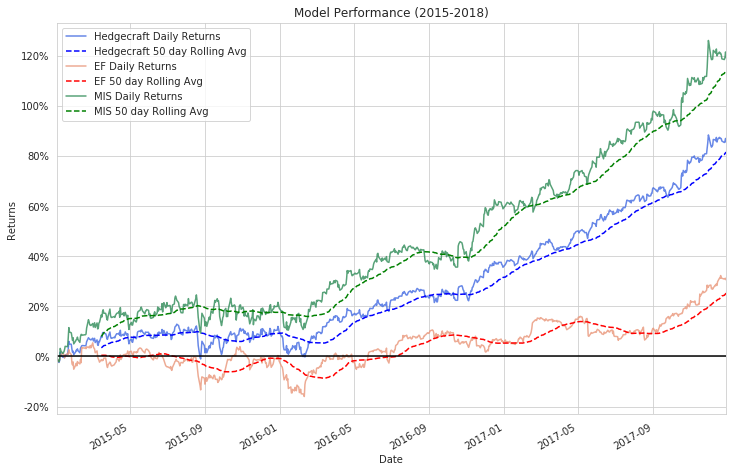

In [0]:
# imports matplotlib submodule to aesthetically place date ticks
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

# returns Hedgecraft 50 day moving avg
rolling_50d_avg = (daily_roi.rename('Hedgecraft 50 day Rolling Avg')
                        .rolling(50)
                        .mean()
)

# returns Efficient Frontier 50 day moving avg
ef_rolling_50d_avg = (ef_daily_roi.rename('EF 50 day Rolling Avg')
                            .rolling(50)
                            .mean()
)

# returns Hedgecraft MIS 50 day moving avg
mis_rolling_50d_avg = (mis_daily_roi.rename('MIS 50 day Rolling Avg')
                                .rolling(50)
                                .mean()
)

with sns.axes_style('whitegrid'):
    # initializes figure and axis
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)

    # gets xtick postions for datetime objects, set minimum number of xticks to 3
    xtick_locator = AutoDateLocator(minticks=3)

    # aesthetically formats xticks
    xtick_formatter = AutoDateFormatter(xtick_locator)


    # returns pretty seaborn plot of hedgecraft returns and its 50 day rolling avg
    daily_roi.plot(color='royalblue', alpha=0.8)
    rolling_50d_avg.plot(color='blue', ls='dashed')

    # returns pretty seaborn plot of EF returns and its 50 day rolling avg
    ef_daily_roi.plot(color='darksalmon', alpha=0.8)
    ef_rolling_50d_avg.plot(color='red', ls='dashed')

    # returns pretty seaborn plot of hedgecraft MIS returns and its 50 day rolling avg
    mis_daily_roi.plot(color='seagreen', alpha=0.8)
    mis_rolling_50d_avg.plot(color='green', ls='dashed')

    # renders xticks, sets ylabel, and turns legend on
    ax.xaxis.set_major_locator(xtick_locator)
    ax.xaxis.set_major_formatter(xtick_formatter)
    ax.set_title('Model Performance (2015-2018)')
    ax.set_ylabel('Returns')
    ax.legend()

    # gets ytick labels and converts to pct format
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:.0f}%'.format(x) for x in vals])

    # draws a horizontal line at 0, turns grid on
    plt.axhline(0, color='black');
    plt.tick_params(left=False, bottom=False)


Pictured above are the daily returns for Hedgecraft MIS (solid green curve), Hedgecraft (solid blue curve), and the Efficient Frontier portfolio (solid red curve) from 2015 to 2018. The color-coded dashed curves represent the 50 day rolling averages of the respective portfolios. Several observations pop: (1) Hedgecraft MIS significantly outperformed Hedgecraft **751 out of 756** trading days, (2) Hedgecraft substantially outperformed the Efficient Frontier **752 out of 756** trading days, (3) Hedgecraft MIS grew $119.1\%$ larger, falling below $0\%$ returns $4$ out of $756$ trading days, (4) Hedgecraft grew $85.4\%$ larger, falling below $0\%$ returns $12$ out of $756$ trading days, and (5) the Efficient Frontier grew $30.5\%$ larger while experiencing negative returns $255$ out of $756$ trading days. Next, let's observe the annual returns for each portfolio and compare them with the market.

In [0]:
returns_summary

,Hedgecraft Returns,Hedgecraft MIS Returns,Efficient Frontier Returns,Dow Return Rates,S&P500 Return Rates,Hedgecraft Return Rates,Hedgecraft MIS Return Rates,Efficient Frontier Return Rates
2015,9.8%,19.3%,-1.8%,0.1%,-0.73%,9.8%,19.3%,-1.8%
2016,35.5%,58.9%,5.5%,16.28%,9.54%,25.7%,39.6%,7.3%
2017,85.4%,119.1%,30.5%,27.97%,19.42%,49.9%,60.2%,25.0%


In comparison, the Dow had a 0.10%, 16.28%, and 27.97% annual return rate in 2015, 2016, and 2017, respectively. The S&P500 had a -0.73%, 9.54%, and 19.42% annual return rate in the same respective years. **Hedgecraft and Hedgecraft MIS substantially outperformed both the market and the Efficient Frontier.** Both Hedgecraft portfolios grew at an impressive rate. Hedgecraft MIS grew 33.7% larger than Hedgecraft and 88.7% larger than the Efficient Frontier, while Hedgecraft grew 54.9% larger than the Efficient Frontier. What's more, Hedgecraft MIS's return rates consistently increased about 20% every year, whereas the return rates of Hedgecraft and the Efficient Frontier were less consistent. Hedgecraft MIS clearly has the most consistent rate of growth. We'd expect this rapid growth to be accompanied with a large burden of risk---either manifested as a large degree of volatility, steep and frequent maximum drawdowns, or both. As we explore below, the Hedgecraft portfolios' sustained their growth rates with significantly less risk exposure than the Efficient Frontier.

# Visualizing Drawdowns

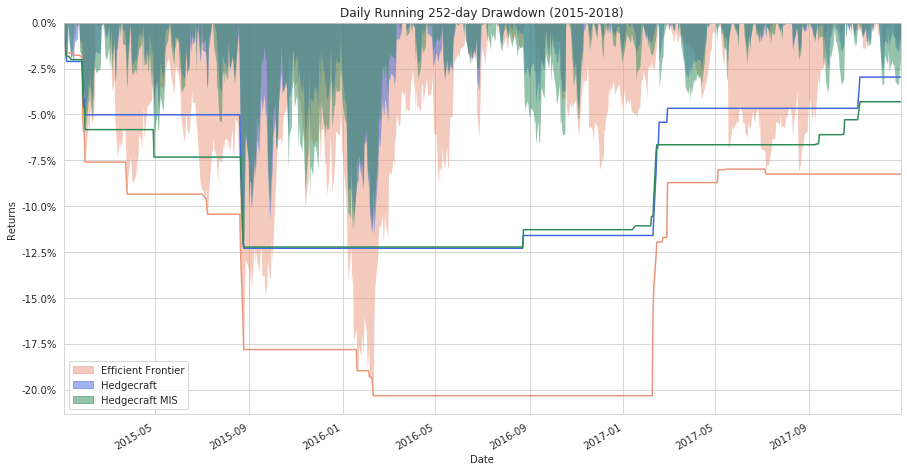

In [0]:
# imports tool to build legends
import matplotlib.patches as mpatches

with sns.axes_style('whitegrid'):
    # initializes figure and axis
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)

    # gets xtick postions for datetime objects, set minimum number of xticks to 3
    xtick_locator = AutoDateLocator(minticks=3)

    # aesthetically formats xticks
    xtick_formatter = AutoDateFormatter(xtick_locator)

    ef_daily_drawdown.plot.area(ax=ax, linewidth=0, alpha=0.5, color='darksalmon')
    ef_max_daily_drawdown.plot(color='darksalmon')

    daily_drawdown.plot.area(ax=ax, linewidth=0, alpha=0.5, color='royalblue')
    max_daily_drawdown.plot(color='royalblue')

    mis_daily_drawdown.plot.area(ax=ax, linewidth=0, alpha=0.5, color='seagreen')
    mis_max_daily_drawdown.plot(color='seagreen')

    # renders xticks, sets ylabel, and turns legend on
    ax.xaxis.set_major_locator(xtick_locator)
    ax.xaxis.set_major_formatter(xtick_formatter)
    
    ax.set_ylabel('Returns')
    
    # sets legend patches color and labels
    ef_patch = mpatches.Patch(color='darksalmon', label='Efficient Frontier', alpha=0.5)
    patch = mpatches.Patch(color='royalblue', label='Hedgecraft', alpha=0.5)
    mis_patch = mpatches.Patch(color='seagreen', label='Hedgecraft MIS', alpha=0.5)
    
    # turns legend on with patches
    plt.legend(handles=[ef_patch, patch, mis_patch])

    plt.tick_params(left=False, bottom=False)
    plt.title('Daily Running 252-day Drawdown (2015-2018)')

     # gets ytick labels and converts to pct format
    vals = ax.get_yticks()
    ax.set_yticklabels([str(round(x*100,2)) + '%' for x in vals])

Illustrated above is the daily rolling 252-day drawdown for Hedgecraft MIS (filled sea green curve), Hedgecraft (filled royal blue curve), and the Efficient Frontier (filled dark salmon curve) along with the respective rolling maximum drawdowns (solid curves). Several observations stick out: (1) the Hedgecraft portfolios have significantly smaller drawdowns than the portfolio generated from the Efficient Frontier, (2) both Hedgecraft portfolios have roughly the same maximum drawdown (about 12.3%), (3) Hedgecraft on average lost the least amount of returns, and (4) Hedgecraft's rolling maximum drawdowns are, on average, less pronounced than Hedgecraft MIS. These results suggest the communicability betweeness centrality has predictive power as a measure of relative or intraportfolio risk, and more generally, that network-based portfolio construction is a promosing alternative to the more traditional approaches like MPT. 

Next, let's observe how each portfolio performed with the metrics we discussed earlier.

In [0]:
backtest_stats

,Hedgecraft,Hedgecraft MIS,Efficient Frontier
Avg Annual Rate of Returns,27.42%,38.7%,9.62%
Annual Volatility,14.58%,18.85%,16.36%
Maximum Drawdown,-12.29%,-12.22%,-20.32%
Annualized Sharpe Ratio,1.74,1.95,0.47
Returns Over Maximum Drawdown,6.95,9.75,1.5
Growth-Risk Ratio,3.33,4.32,0.69


Hedgecraft and its MIS variant dramatically outperformed the Efficient Froniter on every metric (save Hedgecraft MIS's annual volatility). **These results give credence to the possibility that we are on to something substantial here as we have passed the criteria of our go/no go test**. Outperforming MPT by these margins is no simple feat, but, the real test is whether or not Hedgecraft can consistently beat MPT on many randomly generated portfolios (which is the focus of the second part of the Hedgecraft series). To wrap up this notebook, let's take a look at how the returns for each portfolio are distributed and move to the conclusion of *Hedgecraft Part 1*.

# Analyzing the Distribution of Returns

In [0]:
# probability of Hedgecraft losing money
prob_lose_money = (daily_roi[daily_roi < 0].shape[0] 
                       / daily_roi.shape[0]
)

# probability of EF losing money
ef_prob_lose_money = (ef_daily_roi[ef_daily_roi < 0].shape[0] 
                          / ef_daily_roi.shape[0]
)

# probability of Hedgecraft MIS losing money
mis_prob_lose_money = (mis_daily_roi[mis_daily_roi < 0].shape[0] 
                           / mis_daily_roi.shape[0]
)

# Hedgecraft rolling 30 day avg
rolling_30d_avg = (daily_roi.rename('Hedgecraft 30 day Rolling Avg')
                   .rolling(30)
                   .mean()
)

# EF rolling 30 day avg
ef_rolling_30d_avg = (ef_daily_roi.rename('EF 30 day Rolling Avg')
                      .rolling(30)
                      .mean()
)

# Hedgecraft MIS rolling 30 day avg
mis_rolling_30d_avg = (mis_daily_roi.rename('MIS 30 day Rolling Avg')
                       .rolling(30)
                       .mean()
)

# Hedgecraft rolling 90 day avg
rolling_90d_avg = (daily_roi.rename('Hedgecraft 90 day Rolling Avg')
                   .rolling(90)
                   .mean()
)

# EF rolling 90 day avg
ef_rolling_90d_avg = (ef_daily_roi.rename('EF 90 day Rolling Avg')
                      .rolling(90)
                      .mean()
)

# Hedgecraft MIS rolling 90 day avg
mis_rolling_90d_avg = (mis_daily_roi.rename('MIS 90 day Rolling Avg')
                       .rolling(90)
                       .mean()
)

# Hedgecraft list of rolling avgs
rolling_avg_list = [rolling_30d_avg, rolling_50d_avg, rolling_90d_avg]

# EF list of rolling avgs
ef_rolling_avg_list = [ef_rolling_30d_avg, ef_rolling_50d_avg, ef_rolling_90d_avg]

# Hedgecraft MIS list of rolling avgs
mis_rolling_avg_list = [mis_rolling_30d_avg, mis_rolling_50d_avg, mis_rolling_90d_avg]

# Hedgecraft probabilities of falling below 30, 50, and 90 day rolling averages
prob_below_rolling_avgs = []
for i in rolling_avg_list:
    (prob_below_rolling_avgs.append(daily_roi[daily_roi < i].shape[0] 
                                    / daily_roi.shape[0]))

# Efficient Frontier probabilities of falling below 30, 50, and 90 day rolling averages
ef_prob_below_rolling_avgs = []
for i in ef_rolling_avg_list:
    (ef_prob_below_rolling_avgs.append(ef_daily_roi[ef_daily_roi < i].shape[0] 
                                       / ef_daily_roi.shape[0]))

# Hedgecraft MIS probabilities of falling below 30, 50, and 90 day rolling averages
mis_prob_below_rolling_avgs = []
for i in mis_rolling_avg_list:
    (mis_prob_below_rolling_avgs.append(mis_daily_roi[mis_daily_roi < i].shape[0] 
                                        / mis_daily_roi.shape[0]))

# worst day for the Hedgecraft model
max_loss = min(daily_roi)

# worst day for the Efficient Frontier model
ef_max_loss = min(ef_daily_roi)

# worst day for the Hedgecraft MIS model
mis_max_loss = min(mis_daily_roi)

# avg amount of money lost by Hedgecraft when returns fell below 0%
mean_loss = daily_roi[daily_roi < 0].mean()

# avg amount of money lost by EF when returns fell below 0%
ef_mean_loss = ef_daily_roi[ef_daily_roi < 0].mean()

# avg amount of money lost by Hedgecraft MIS when returns fell below 0%
mis_mean_loss = mis_daily_roi[mis_daily_roi < 0].mean()

# Hedgecraft distribution of returns statistics
dist_stats = [
                prob_lose_money*100, 
                max_loss, 
                mean_loss, 
                prob_below_rolling_avgs[0]*100, 
                prob_below_rolling_avgs[1]*100, 
                prob_below_rolling_avgs[2]*100
]

# rounds above list and annotates with % sign
dist_stats = [str(round(x, 2)) + '%' for x in dist_stats]

# Ef distribution of returns statistics
ef_dist_stats = [
                    ef_prob_lose_money*100, 
                    ef_max_loss, ef_mean_loss, 
                    ef_prob_below_rolling_avgs[0]*100,
                    ef_prob_below_rolling_avgs[1]*100, 
                    ef_prob_below_rolling_avgs[2]*100
]

# rounds above list and annotates with % sign
ef_dist_stats = [str(round(x, 2)) + '%' for x in ef_dist_stats]

#  Hedgecraft MIS distribution of returns statistics
mis_dist_stats = [
                    mis_prob_lose_money*100, 
                    mis_max_loss, mis_mean_loss, 
                    mis_prob_below_rolling_avgs[0]*100,
                    mis_prob_below_rolling_avgs[1]*100, 
                    mis_prob_below_rolling_avgs[2]*100
]

# rounds above list and annotates with % sign
mis_dist_stats = [str(round(x, 2)) + '%' for x in mis_dist_stats]

# dictionary of distribution stats
dist_stats_summary = {
                        'Hedgecraft': dist_stats, 
                        'Hedgecraft MIS': mis_dist_stats, 
                        'Efficient Frontier': ef_dist_stats
}

# converts above dict to a DataFrame
dist_stats_summary = pd.DataFrame.from_dict(dist_stats_summary)

# renames the indices
dist_stats_summary = dist_stats_summary.rename(index={
                                 0:'probability of losing money from initial investement', 
                                 1:'maximum loss',
                                 2:'mean loss',
                                 3:'Probability of falling bellow 30 day rolling avg',
                                 4:'Probability of falling bellow 50 day rolling avg',
                                 5:'Probability of falling bellow 90 day rolling avg'
                            }
);

# Visualizing the Distribution of Returns

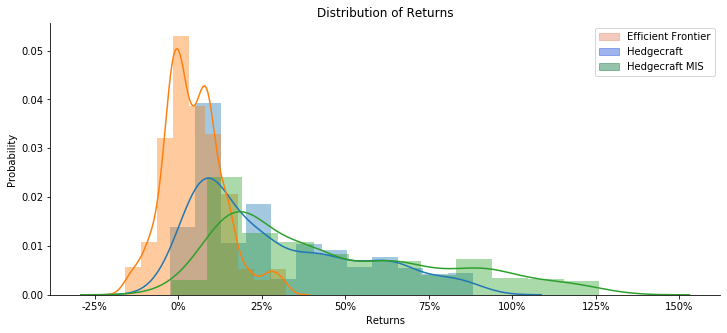

In [0]:
# function to plot many overlaping kde plots
def multi_distplot(rdist1, rdist2, rdist3, kde=True):
    
    # initializes figure and axis
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)

    # pretty seaborn kde plots for each model
    sns.distplot(rdist1, bins=12, kde=bool)
    sns.distplot(rdist2, bins=10, kde=bool)
    sns.distplot(rdist3, bins=12, kde=bool)
    
    # gets xticks
    vals1 = ax.get_xticks()
    
    # reformats xticks to pcts
    ax.set_xticklabels(['{:.0f}%'.format(x) for x in vals1])
    
    # plot labels and title
    ax.set_ylabel('Probability')
    ax.set_xlabel('Returns')
    plt.title('Distribution of Returns')
    
    # removes spines
    sns.despine(top=True, right=True)

    # sets legend patches color and labels
    ef_patch = mpatches.Patch(color='darksalmon', label='Efficient Frontier', alpha=0.5)
    patch = mpatches.Patch(color='royalblue', label='Hedgecraft', alpha=0.5)
    mis_patch = mpatches.Patch(color='seagreen', label='Hedgecraft MIS', alpha=0.5)
    
    # turns legend on with patches
    plt.legend(handles=[ef_patch, patch, mis_patch])
    
multi_distplot(rdist1 = daily_roi, rdist2 = ef_daily_roi, rdist3 = mis_daily_roi)

Above are the returns distribution for each portfolio: Efficient Frontier (in red), Hedgecraft (in blue), and Hedgecraft MIS (in green). The Efficient Frontier algorithm clearly produced a portfolio with a normal distribution of returns; the same can't be said of the Hedgecraft portfolios as they're heavily right-skewed. The right-skewness of the Hedgecraft portfolios is caused by their strong upward momentum, that is, their consistent growth. In general, we'd expect a strong correlation between the right-skewness of the returns distribution and the growth-risk-ratio. 

It's important to emphasize that deviation-based measures of risk-adjusted performance implicitly assume the distribution of returns follows a normal distribution. As such, the Sharpe ratio isn't a suitable measure of performance since the standard deviation isn't a suitable measure of risk for the Hedgecraft portfolios.

In [0]:
dist_stats_summary

,Hedgecraft,Hedgecraft MIS,Efficient Frontier
probability of losing money from initial investement,1.59%,0.53%,33.77%
maximum loss,-2.39%,-2.13%,-15.99%
mean loss,-0.77%,-1.39%,-4.17%
Probability of falling bellow 30 day rolling avg,21.32%,25.17%,38.41%
Probability of falling bellow 50 day rolling avg,16.56%,19.07%,38.01%
Probability of falling bellow 90 day rolling avg,11.79%,15.5%,35.1%


While Hedgecraft had less pronounced maximum drawdowns it was more frequenty bellow 0% returns (1.59% of the time) than its MIS variant (0.53% of the time). These values dwarf that of the Efficient Frontier, which painfully experienced negative returns a third of the time. It's interesting to note that the maximum loss of the Hedgecraft portoflios is an order of magnitude smaller than their maximum drawdowns. This relationship is in contrast to the Efficient Frontier's maximum loss which is on the same order of magnitude as its maximum drawdown. It's also interesting to point out that Hedgecraft has a lower probability of falling below its rolling 30, 50, and 90 averages than its MIS variant. Taken together, Hedgecraft's smaller average rolling maximum drawdown and smaller probabilities of falling below the above rolling averages indicate its growth is more consistent than its MIS variant. On the one hand, Hedgecraft's *growth* is more consistent than its MIS variant while on the other hand, the MIS variant has a more consistent *growth rate*. Stated another way: Hedgecraft's "velocity of returns" is more consistent than that of the MIS variant's, whereas Hedgecraft MIS's "acceleration of returns" is more consistent than that of the Hedgecraft portoflio.

# Conclusion

In this notebook we built a novel algorithm for generating asset weights of a minimally correlated portoflio with tools from network science. Our approach is twofold: we first construct an asset correlation network with energy statistics (i.e., the distance correlation) and then extract the asset weights with a suitbale centrality measure. As an intermediate step we interpret the centrality score (in our case the communicability betweeness centrality) as a measure of relative risk as it quantifies the influence of each asset in the network. The communicability betweeness centrality is a particularly attractive choice since it captures the communicability of asset volatility. Recognizing the need for a human-in-the-middle variation of our proposed method, we modified the asset allocation algorithm to allow a user to pick assets subject to the constraints of the maximal independent set. Both algorithms (Hedgecraft and Hedgecraft MIS, including the benchmark Efficient Frontier) were trained on a dataset of thirty-one daily historical stock prices from 2006-2014 and tested from 2015-2018. The portfolios were evaluated by cumulative returns, return rates, volatility, maximum drawdowns, risk-adjusted return metrics, and downside risk-adjusted performance metrics. **On all performance metrics, the Hedgecraft algorithm significantly outperformed both the portfolio generated by the Efficient Frontier and the market---passing our go/no go criteria.**

# Roadmap

In part two of the *Hedgecraft* series we will further validate the method by testing on (1) a multitude of randomly generated portfolios, (2) on many asset classes, and (3) on a representative sample of the entire market (including many asset classes). In order to achieve this level of backtesting we first focus on building the Hedgecraft library. Additionally, these are the following questions we'll explore later in the series:

* How robust is the Hedgecraft portfolio to large market swings and economic downturns?
* How do asset correlation networks evolve in time? Can we predict how a network's topology changes in time, and if so, how well? Which is easier to predict: the topology of an asset network or the prices of an individual asset?
* How can we use a combination of link prediction and machine learning to predict the behavior of asset correlation networks? How can we modify Hedgecraft to make it dynamic---essentially operating it as a trading algorithm?
* What kind of end-to-end user product can we build with Hedgecraft?